In [1]:
#import user modules
#--- MATPLOTLIB
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd

import sys
my_path = "../../Python/"
if my_path not in sys.path:
    sys.path.append(my_path)
 
for place in sys.path: 
    print(place)

from tools import *
from fit_funcs import *
from entropy import *
import costfun.costfun as cost
import utils.figures as fig_help
from RandomMatrixTheory import goe
import utils.tools as tools

import importlib as imp
def reload_modules():
    imp.reload(cost)
    imp.reload(fig_help)

import itertools
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
latex_engine = 'xelatex'
latex_elements = {'preamble':r'\usepackage{physics}'}

%matplotlib inline
colors_ls = (list(mcolors.TABLEAU_COLORS)[:200])
colors_ls_cyc = itertools.cycle(colors_ls)

markers_ls = ['o','s','v', 'D', '<', 'X', '^', '*', '+']
markers = itertools.cycle(markers_ls)

linestyle_ls = ['-','--',':', '-.']
linestyle = itertools.cycle(linestyle_ls)

#--- NUMERICAL LIBS
import numpy as np
import itertools
import math
import random
from cmath import nan
import h5py   


# SCIPY LIBS
import scipy.stats as statistics
from scipy.special import binom
from scipy.special import erfinv
from scipy.special import digamma
from scipy.special import polygamma
from scipy.special import lambertw
from scipy.optimize import curve_fit as fit
from scipy.signal import savgol_filter
from scipy import integrate
from scipy import fft
from scipy.interpolate import UnivariateSpline as InterpolateSpline
from scipy.interpolate import make_interp_spline as make_spline
 
# OTHER
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel, delayed
import copy
import os
from os import sep as kPSep
from os.path import exists

base_dir = "../results/"

print(base_dir[2:])

/Users/rafal.swietek/Projects/CODES/QHamSolver/QREM/Jupyter_Python
/Users/rafal.swietek/opt/anaconda3/lib/python39.zip
/Users/rafal.swietek/opt/anaconda3/lib/python3.9
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/lib-dynload

/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/aeosa
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/locket-0.2.1-py3.9.egg
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions
/Users/rafal.swietek/.ipython
../../Python/
/results/


$$\Large H=\sum_{j=1}^L h_j\sigma^z_j+\frac{1}{\sqrt{L}}\sum_{i\neq j=1}^LJ_{ij}\sigma^z_i\sigma^z_j+\frac{g}{L\ln{L}}\sum_{j=1}^L\sigma^x_j$$
$$\Large h_j,J_{i,j}\sim\mathcal{N}(0,1)$$

## SAVER

In [33]:
L=15
g=1.0


plot_gaps = 1

b = 1.5

# g_vals = np.linspace(0.5, 15.5, 31)
g_vals = np.array([*np.linspace(0.1, 4, 40), *np.linspace(4.2, 10, 30)])
g_vals = np.linspace(0.15, 2., 38)
print(g_vals)

sub_sizes = np.arange(0, L+1)

sizes = np.arange(16, 17, 1)

interpolate = 1

nu = 500

# for nu in [500, 0.1, 0.25, 0.5, 1.0]:
for nu in [500]:
    frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu

    folder_base = f'./collected data/'
    folder = folder_base + base_dir[3:] + f"nu={nu}/"
    os.makedirs(folder_base, exist_ok=True)
    os.makedirs(folder, exist_ok=True)

    perturbation = []
    gaps = []
    Ssite_av = []
    for L in sizes:
        # g_vals = np.linspace(0.1, 4, 40) if L > 12 else np.array([*np.linspace(0.05, 2, 40), *np.linspace(2.2, 10, 40)])
        sub_sizes = np.arange(0, L+1)
        name_out = folder + f'_L={L}.hdf5'

        entropy         = np.zeros((sub_sizes.size, g_vals.size)); entropy.fill(np.nan)
        entropy_site    = np.zeros((sub_sizes.size, g_vals.size)); entropy_site.fill(np.nan)
        gap_ratio       = np.zeros((g_vals.size));                 gap_ratio.fill(np.nan)
        realisations    = np.zeros((g_vals.size));                 realisations.fill(np.nan)
        Sinfo_vN        = np.zeros((g_vals.size));                 Sinfo_vN.fill(np.nan)
        for ii, g in enumerate(g_vals):
            name = base_dir + 'Entropy/Eigenstate/' + info(L=L, g=g, ext='.hdf5')
            
            if exists(name):
                with h5py.File(name, "r") as file:
                    energies = np.array(file.get('mean energies'))
                    ratio = np.array(file.get('gap ratio'))
                    realis = np.array(file.get('realisations'))[0]
                    realisations[ii] = realis
                    
                    dim = energies.size
                    num = frac(dim)
                    if nu > 1:
                        num = min([num, int(0.1*dim)])
                    # print(dim, num)
                    E_av = np.mean(energies)
                    index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                    
                    my_min = int(index_meanE - num / 2)
                    if my_min < 0: my_min = 0;  

                    my_max = int(index_meanE + num / 2)
                    if my_max >= dim: my_max = dim
                    Sinfo = np.array(file.get('von Neumann participation entropy'))

                    try:
                        # if num == 500:          gap_ratio[ii] = np.array(file.get('gap ratio 500'))
                        # elif num == dim//2:     gap_ratio[ii] = np.array(file.get('gap ratio D/2'))
                        # else:
                        #     # print("otherwise")
                        gap_ratio[ii] = np.mean(ratio[my_min : my_max]) if my_min > 0 and my_max < dim and num < dim else np.mean(ratio)
                        
                        Sinfo_vN[ii] = np.mean(Sinfo[my_min : my_max]) if my_min > 0 and my_max < dim and num < dim else np.mean(Sinfo)
                        for LA in sub_sizes:
                            S = np.array(file.get('entropies'))[LA]
                            Ssite = np.array(file.get('single_site_entropy'))[LA]
                            entropy[LA][ii]         = np.mean(S[my_min : my_max]) if my_min > 0 and my_max < dim and num < dim else np.mean(S)
                            entropy_site[LA][ii]    = np.mean(Ssite[my_min : my_max]) if my_min > 0 and my_max < dim and num < dim else np.mean(Ssite)
                    except TypeError:
                        print(ratio)
            else:
                print(name)
        if not np.all( np.isnan(realisations) ):
            print("SAVED:", name_out, np.min(realisations), np.max(realisations))
            hf = h5py.File(name_out, 'w')
            hf.create_dataset('perturbation',           g_vals.shape,           data = g_vals)
            hf.create_dataset('gap_ratio',              gap_ratio.shape,        data = gap_ratio)
            hf.create_dataset('entropy',                entropy.shape,          data = entropy)
            hf.create_dataset('single_site_entropy',    entropy_site.shape,     data = entropy_site)
            hf.create_dataset('realisations',           realisations.shape,     data = realisations)
            hf.create_dataset('vN info entropy',        Sinfo_vN.shape,         data = Sinfo_vN)
            hf.close()
    

[0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75 0.8
 0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5
 1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ]
../results/Entropy/Eigenstate/_L=16,g=1.55.hdf5
../results/Entropy/Eigenstate/_L=16,g=1.6.hdf5
../results/Entropy/Eigenstate/_L=16,g=1.65.hdf5
../results/Entropy/Eigenstate/_L=16,g=1.7.hdf5
../results/Entropy/Eigenstate/_L=16,g=1.75.hdf5
../results/Entropy/Eigenstate/_L=16,g=1.8.hdf5
../results/Entropy/Eigenstate/_L=16,g=1.85.hdf5
../results/Entropy/Eigenstate/_L=16,g=1.9.hdf5
../results/Entropy/Eigenstate/_L=16,g=1.95.hdf5
../results/Entropy/Eigenstate/_L=16,g=2.hdf5
SAVED: ./collected data/results/nu=500/_L=16.hdf5 nan nan


## RAW DATA

8 5000.0 5000.0
9 4750.0 5000.0
10 4750.0 5000.0
11 5000.0 5000.0
12 3800.0 4000.0
13 2768.0 3000.0
14 2356.0 2694.0
15 600.0 948.0
16 nan nan


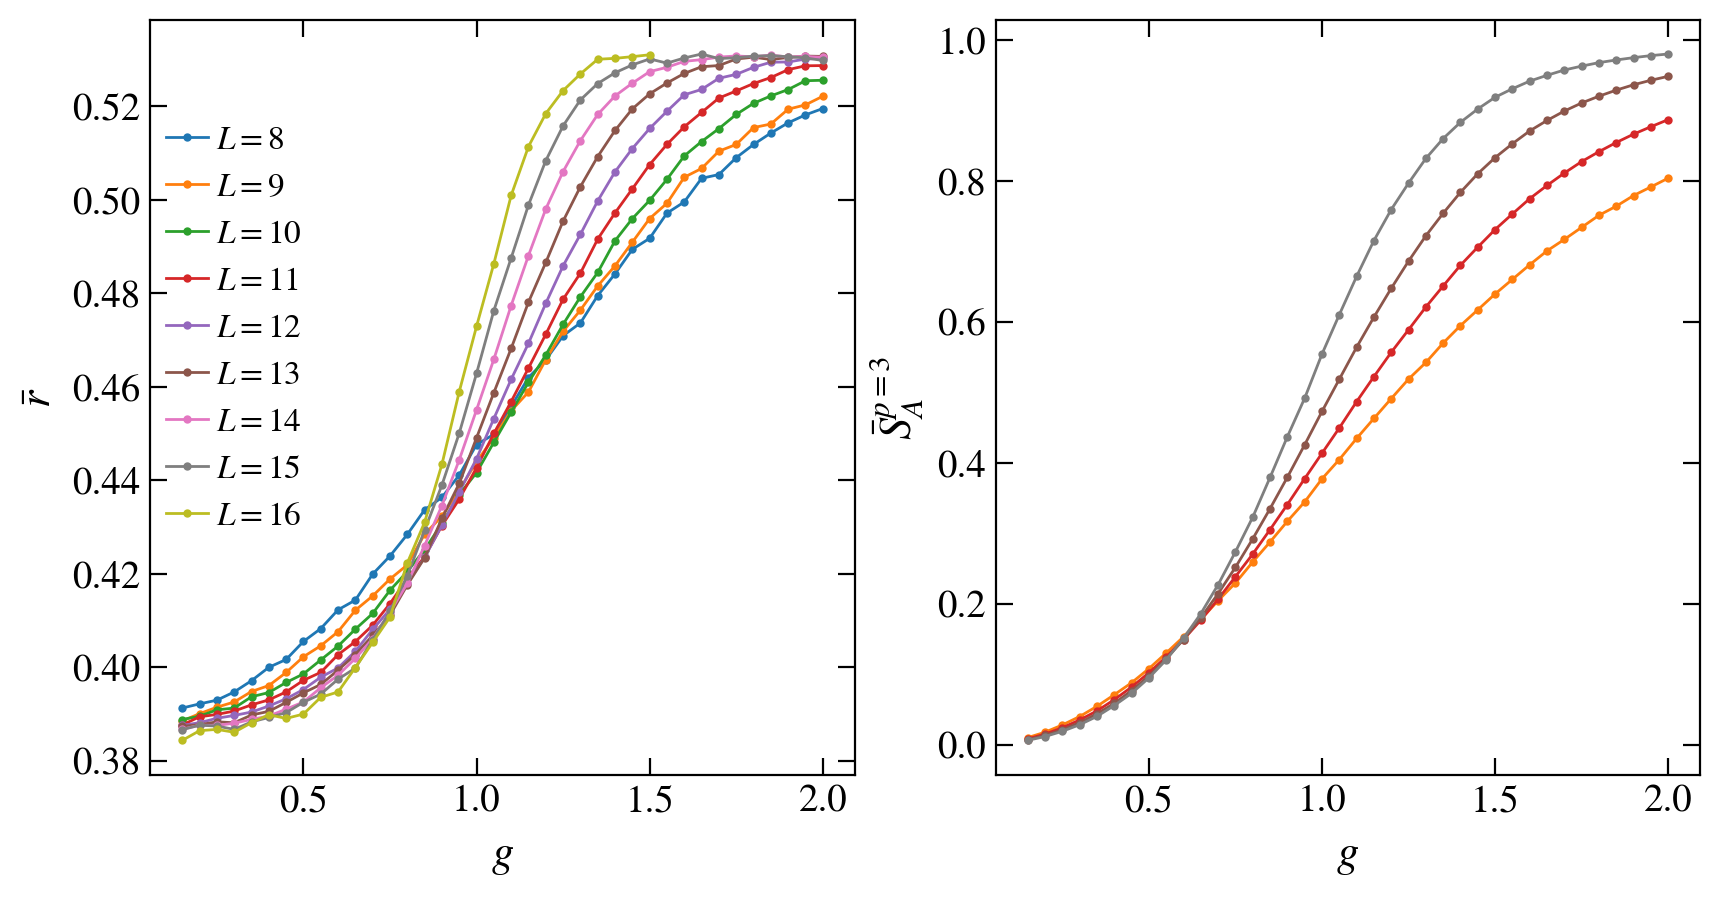

In [29]:
L=15
g=1.0

sub_sizes = np.arange(0, L+1)

sizes = np.arange(8, 17, 1)

interpolate = 0

nu = 500
frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu

folder_base = f'./collected data/'
folder = folder_base + base_dir[3:] + f"nu={nu}/"
os.makedirs(folder_base, exist_ok=True)
os.makedirs(folder, exist_ok=True)

rescale_func        = [lambda x, L: x]#, lambda x, L: x * np.log(L), lambda x, L: x * np.sqrt(L)/np.log(L)]
rescale_func_names  = [r"$g$"        ]#, r"$g\cdot\ln{L}$"         , r"$g\cdot\sqrt{L}/\ln{L}$"]


fig, axes = plt.subplots( nrows=len(rescale_func), ncols=2, figsize=(10,5 * len(rescale_func)), dpi = 200, sharex='row')

perturbation = []
gaps = []
Ssite_av = []
for L in sizes:
    LA = 3

    sub_sizes = np.arange(0, L+1)
    name_out = folder + f'_L={L}.hdf5'

    if exists(name_out):
        with h5py.File(name_out, "r") as file:
            g_vals       = np.array(file.get('perturbation'))
            gap_ratio    = np.array(file.get('gap_ratio'))
            entropy      = np.array(file.get('entropy'))
            entropy_site = np.array(file.get('single_site_entropy'))
            realisations = np.array(file.get('realisations'))
            print(L, np.min(realisations), np.max(realisations))
    else:
        print(name_out)
    
    ent = np.zeros(g_vals.shape)
    for ii in range(g_vals.size):
        ent[ii] = np.transpose(entropy)[ii][LA] / page(LA, L - LA)
        # ent[ii] = np.mean(np.transpose(entropy_site[:-1])[ii]) / page(1, L-1)
    
    perturbation.append( g_vals )
    gaps.append(gap_ratio)
    Ssite_av.append(ent)

for iabc in range(len(rescale_func)):
    xlab = rescale_func_names[iabc]
    axis = [axes[iabc][0], axes[iabc][1]] if len(rescale_func) > 1 else axes
    for ii, L in enumerate(sizes):
        col = next(colors_ls_cyc)
        g_vals_resc = rescale_func[iabc](perturbation[ii], L)
        if interpolate:
            r_spl = InterpolateSpline(g_vals_resc, gaps[ii],   k=5)
            S_spl = InterpolateSpline(g_vals_resc, Ssite_av[ii], k=5)
            
            # bucket = 100
            # xx        = np.sort( np.array([*np.linspace(perturbation[ii][0], perturbation[ii][-1], 1000), *perturbation[ii]]) )
            # gap_ratio = tools.remove_fluctuations(r_spl(xx), bucket_size=bucket)[bucket//2 : -bucket//2]
            # entropy   = tools.remove_fluctuations(S_spl(xx), bucket_size=bucket)[bucket//2 : -bucket//2]
            
            gap_ratio = r_spl(g_vals_resc)
            entropy   = S_spl(g_vals_resc)
        else:
            gap_ratio = gaps[ii]
            entropy = Ssite_av[ii]
        axis[0].plot(g_vals_resc, gap_ratio, marker='o', markersize=2, lw=1, label=r"$L=%d$"%L, color=col)
        if L % 2 == 1:
            axis[1].plot(g_vals_resc, entropy,   marker='o', markersize=2, lw=1, color=col)

    # axis[0].set_ylim(0.38,0.46)
    # axis[1].set_ylim(0.0,0.46)
    # if iabc == 0:   
    #     axis[0].set_xlim(2.0, 8.0)
    # elif iabc == 1:   
    #     axis[0].set_xlim(10.0, 25.0)
    # elif iabc == 2:   
    # axis[0].set_xlim(0.05, 4.0)
    # axis[1].set_xlim(0.05, 4.0)


    # axis[1].set_xlim(4 * min(np.array(perturbation).flatten()), 0.8*max(np.array(perturbation).flatten()))
    # axis[0].axhline(y=0.3863, ls='--', color='black')
    # axis[0].axhline(y=0.5307, ls='--', color='black')

    # axis[1].set_ylim(0.3 + 0.1*iabc,0.9)

    fig_help.set_plot_elements(axis[0], ylabel=r"$\bar{r}$", xlabel=xlab, font_size=14, set_legend=False, xscale='log')
    fig_help.set_legend(axis[0], loc = 'upper left', fontsize=12, anchor=(-0.02, 0.9))

    fig_help.set_plot_elements(axis[1], ylabel=r"$\bar{S}_A^{p=%d}$"%LA, xlabel=xlab, font_size=14, set_legend=False, xscale='linear')

    # for ax in axis:
    #     ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
    #     ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
    #     ax.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
    #     ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))


fig.subplots_adjust(wspace = 0.2, hspace=0.2)

In [33]:
j = np.linspace(0, 1, 100)

def funn(L, real):
    return real * (2*(L+1) + 3) * 2**L * 8 / 1e9

def memsize(L):
    return (2*(L+1) + 3) * 2**L * 8 / 1e6


sizes = [8, 9, 10, 11, 12, 13, 14, 15, 16]
mems = [0.05, 0.1, 0.219, 0.457, 0.965, 2, 4.3, 9.2, 19.4]
reals = [1e4, 1e4, 1e4, 8e3, 8e3, 5e3, 4.5e3, 1.5e3, 500]
reals2 = [5e4, 5e3, 5e3, 5e3, 5e3, 3e3, 3e3, 1.5e3, 1e3]

sum = 0
sum2 = 0
for ii, L in enumerate(sizes):
    sum += 30 * 3 * funn(L, reals[ii])
    sum2 += 30 * 3 * funn(L, reals2[ii])
    # print(L, memsize(L) * reals[ii]/1e3, funn(L, reals[ii]))
    print(L, 30 * 3 * funn(L, reals2[ii]))

print("Sum=", sum, "GB")
print("Sum2=", sum2, "GB")


8 193.536
9 42.3936
10 92.16
11 199.0656
12 427.6224
13 548.5363199999999
14 1167.85152
15 1238.6304
16 1745.8790399999998
Sum= 6088.0896 GB
Sum2= 5655.67488 GB


## INFORMATION ENTROPY

9 42 9.00900900900901
10 83 9.993993993993994
11 125 11.003003003003002
12 166 11.987987987987989
13 208 12.996996996996998
14 250 14.006006006006006
15 291 14.99099099099099


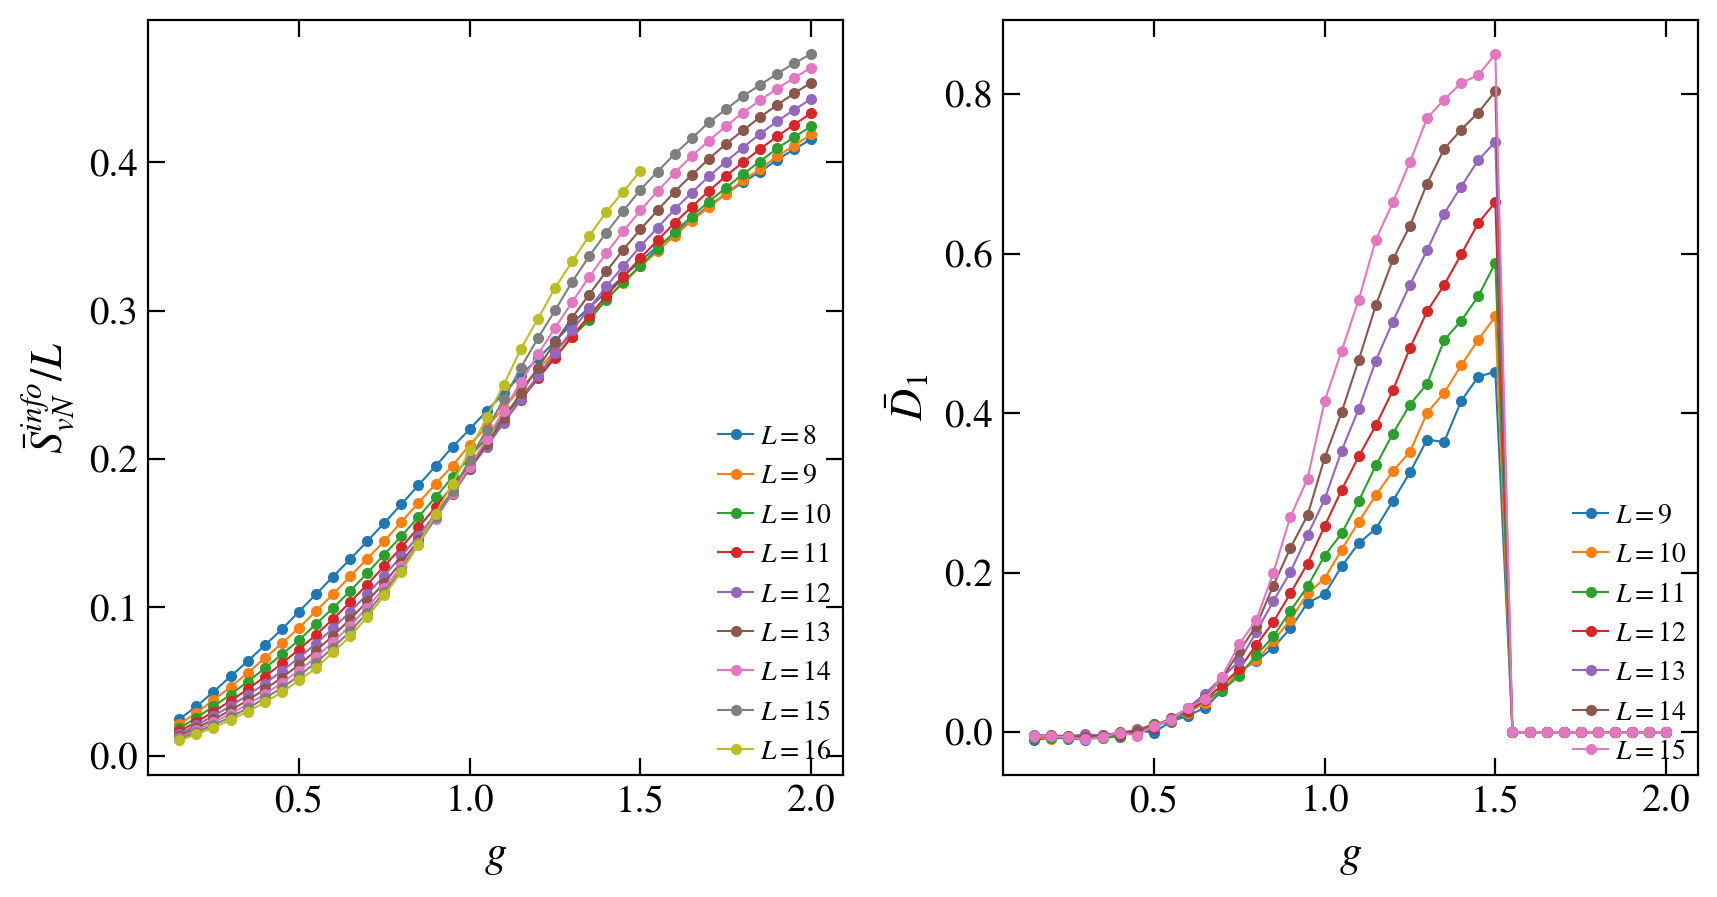

In [34]:
L=15
g=1.0

fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 200, sharex=True)

sizes = np.arange(8, 17, 1)

nu = 500
frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu

folder_base = f'./collected data/'
folder = folder_base + base_dir[3:] + f"nu={nu}/"
os.makedirs(folder_base, exist_ok=True)
os.makedirs(folder, exist_ok=True)
    
xlab = r"$g$"
g_crit = 0.75
interpolate=1

interaction = []
Sinfo = []
for L in sizes:
    name_out = folder + f'_L={L}.hdf5'

    if exists(name_out):
        with h5py.File(name_out, "r") as file:
            g_vals   = np.array(file.get('perturbation'))
            Sinfo_vN = np.array(file.get('vN info entropy'))
            
        interaction.append(g_vals)
        Sinfo.append(Sinfo_vN)
    else:
        print(name_out)

for ii, L in enumerate(sizes):
    axis[0].plot(interaction[ii], Sinfo[ii] / L, marker='o', markersize=3, lw=0.75, label=r"$L=%d$"%(L))
    # axis[idx1].plot(rescale_fun(disorder[ii], sizes, ii, critical_fun, par, *crit_pars), gaps[ii], ls='--', marker='o', label=r"$L=%d$"%(L))

Sinfo = np.transpose(Sinfo)
xx = np.linspace(sizes[0], 2*sizes[-1], 1000) if interpolate else sizes
D1 = np.zeros((g_vals.size, xx.size - 1))
for ii_a, g in enumerate(g_vals):
    
    if any(np.isnan(Sinfo[ii_a])): continue
    if interpolate:
        spl = make_spline(sizes, Sinfo[ii_a] / np.log(2))
        yy = spl(xx)
        yy = tools.remove_fluctuations(yy, 20)[:-1]
        D1[ii_a] = np.gradient(yy, xx[1] - xx[0])
    else:
        D1_tmp = np.diff(Sinfo[ii_a]) / np.log(2)
        # D1[ii_a] = ( D1_tmp[:-1] + D1_tmp[1:] ) / 2.0
        D1[ii_a] = D1_tmp
D1 = np.transpose(D1)
for ii, L in enumerate(sizes[1 : -1]):
    ii_L = (np.abs(xx - L)).argmin()
    print(L, ii_L, xx[ii_L])
    axis[1].plot(interaction[ii], D1[ii_L], marker='o', markersize=3, lw=0.75, label=r"$L=%d$"%(L))

# axis[0].axvline(x=1/np.sqrt(2), ls='--', c='k')
# axis[0].axvline(x=g_crit, ls=':', c='k')
# axis[1].axvline(x=1/np.sqrt(2), ls='--', c='k')
# axis[1].axvline(x=g_crit, ls=':', c='k')


fig_help.set_plot_elements(axis[1], ylabel=r"$\bar{D}_1$", xlabel=xlab, font_size=14, set_legend=False)
fig_help.set_legend(axis[1], loc = 'lower right', fontsize=10)
fig_help.set_plot_elements(axis[0], ylabel=r"$\bar{S}^{info}_{vN}/L$", xlabel=xlab, font_size=14, set_legend=False)
fig_help.set_legend(axis[0], loc = 'lower right', fontsize=10)

# for aa in [axis]:
#     for ax in np.array(aa).flatten():
#         ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
#         ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
#         ax.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
#         ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))

fig.subplots_adjust(wspace = 0.23, hspace=0.23)


## COLLAPSE

In [129]:
N=5
gamma=1.0
alfa=1.0
critfun='free'
ansatz='classic'

for critfun in ['free']:
    for ansatz in ['classic', 'RG', 'KT']:
        for nejm in ["GapRatio", "Thouless"]:
            critical_points = []
            nus = []
            CF = []

            filename = f"{nejm}_critfun=%s_ansatz=%s"%(critfun, ansatz)
            dirname = './CriticalParameters/'
            for files in os.listdir(dirname + 'raw/'):
                if files.startswith(filename):
                    # print(files)  # printing file name of desired extension
                    with h5py.File(dirname + 'raw/' + files, "r") as file:
                        nus.append( np.array(file.get('crit exp')) )
                        critical_points.append( np.array(file.get('crit_pars')) )
                        CF.append( np.array(file.get('costfun')) )
                else:
                    continue

            # print(critical_points)
            CF = np.array(CF)
            nus = np.array(nus)
            critical_points = np.array(critical_points)
            print(CF)
            hf = h5py.File(dirname + filename + '.hdf5', 'w')
            hf.create_dataset('crit_pars', critical_points.shape,   data = critical_points)
            hf.create_dataset('crit exp',  nus.shape,               data = nus)
            hf.create_dataset('costfun',   CF.shape,                data = CF)
            hf.close()

[1.41373934 1.40334475 1.41373934 1.40888525 1.41987513 1.40334475
 1.41063013 1.40504327 1.40334475 1.43514294 1.40485577 1.41373934
 1.41373934 1.41373934 1.41373934 1.41157371 1.41373934 1.43097053
 1.41063013 1.41373934 1.41373934 1.40610675 1.41373934 1.41373934
 1.41373934 1.41736665 1.41736665 1.41373934 1.41543694 1.40214836
 1.40610675 1.40905745 1.41323287 1.40485577 1.4300397  1.41373934
 1.40888525 1.41373934 1.40977844 1.41373934 1.39859627 1.40485577
 1.40334475 1.41373934 1.41373934 1.41063013 1.41615335 1.41373934
 1.41373934 1.41373934 1.41373934 1.40888525 1.41373934 1.41373934
 1.41323287 1.40888525 1.41373934 1.40977844 1.41373934 1.41373934
 1.41543694 1.4190625  1.41373934 1.40911911 1.41323287 1.41063013
 1.41183345 1.41373934 1.40610675 1.40965884 1.40214836 1.41543694
 1.40334475 1.40977844 1.40485577 1.40485577 1.41373934 1.41183345
 1.41373934 1.41373934 1.41183345 1.41373934 1.41373934 1.4205907
 1.40888525 1.4300397  1.41373934 1.40610675 1.41373934 1.40888

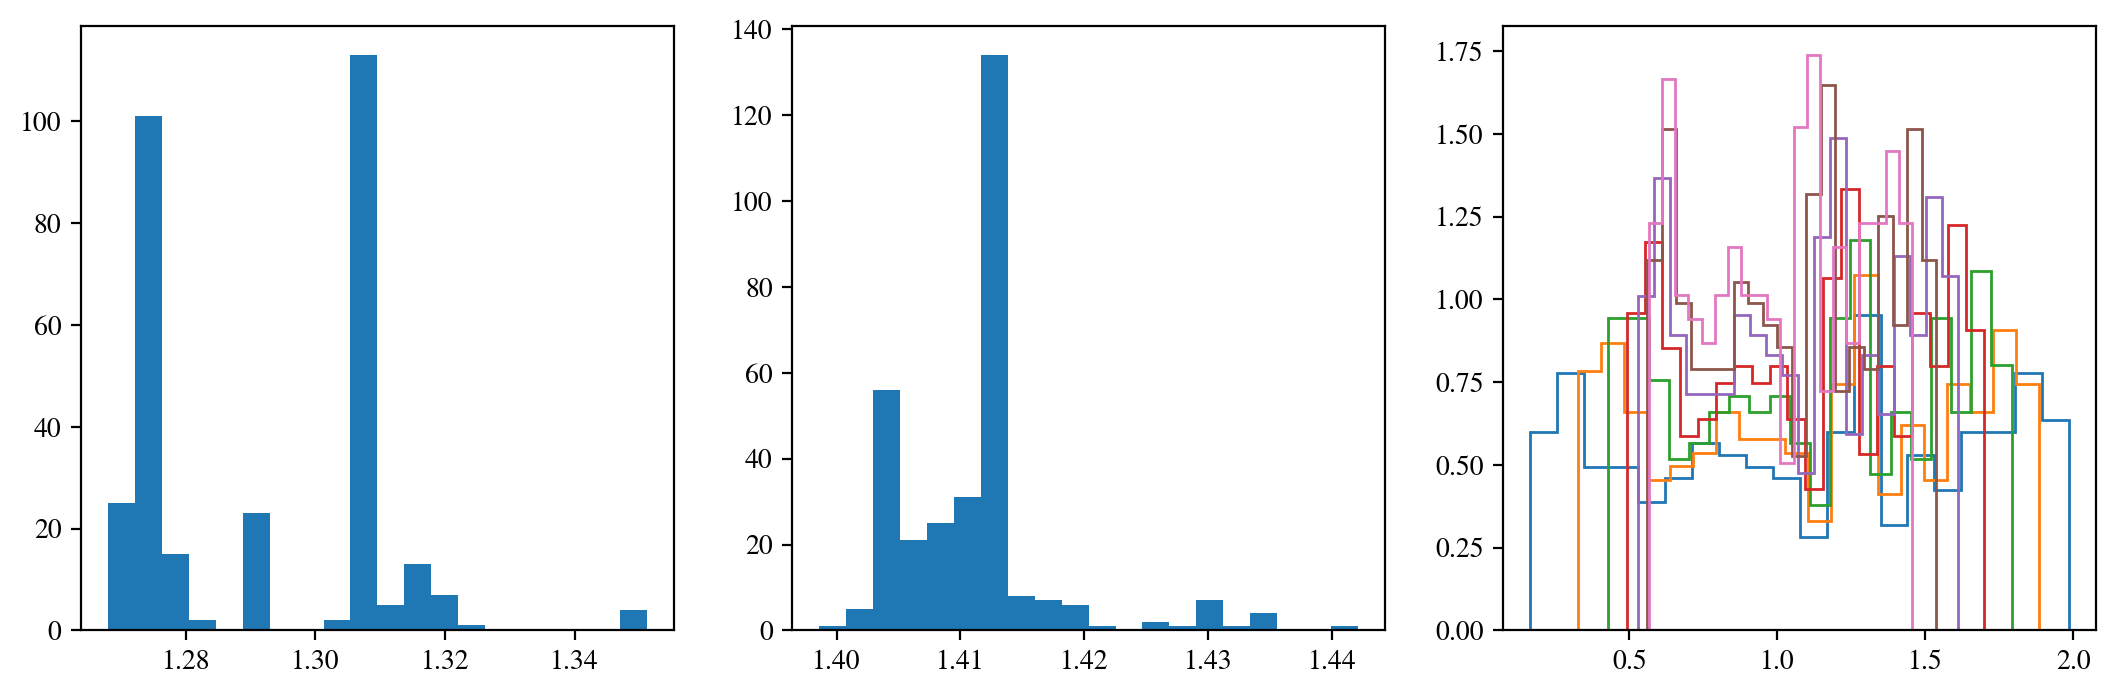

In [158]:
N=5
gamma=1.0
alfa=1.0

critfun='free'
ansatz='classic'
nejm = "GapRatio"
# nejm = "Thouless"
filename = f"CriticalParameters/{nejm}_critfun=%s_ansatz=%s.hdf5"%(critfun, ansatz)

if exists(filename):
    with h5py.File(filename, "r") as file:
        crit_pars   = np.transpose(np.array(file.get('crit_pars')))
        crit_exp    = np.array(file.get('crit exp'))
        CF          = np.array(file.get('costfun'))
    
fig, axis = plt.subplots( nrows=1, ncols=3 + int(not critfun == 'free'), figsize=(13,4), dpi = 200)
axis[0].hist(crit_exp, bins=20)
axis[1].hist(CF, bins=20)

sizes = np.arange(8, 15, 1)
if critfun == 'free':
    for ii in range(len(sizes)):
        hist, edges = np.histogram(crit_pars[ii], bins=20, normed=True)
        axis[2].stairs(hist, edges)
else:
    for ii in range(len(crit_pars)):
        hist, edges = np.histogram(crit_pars[ii], bins=20, normed=True)
        axis[2+ii].stairs(hist, edges)

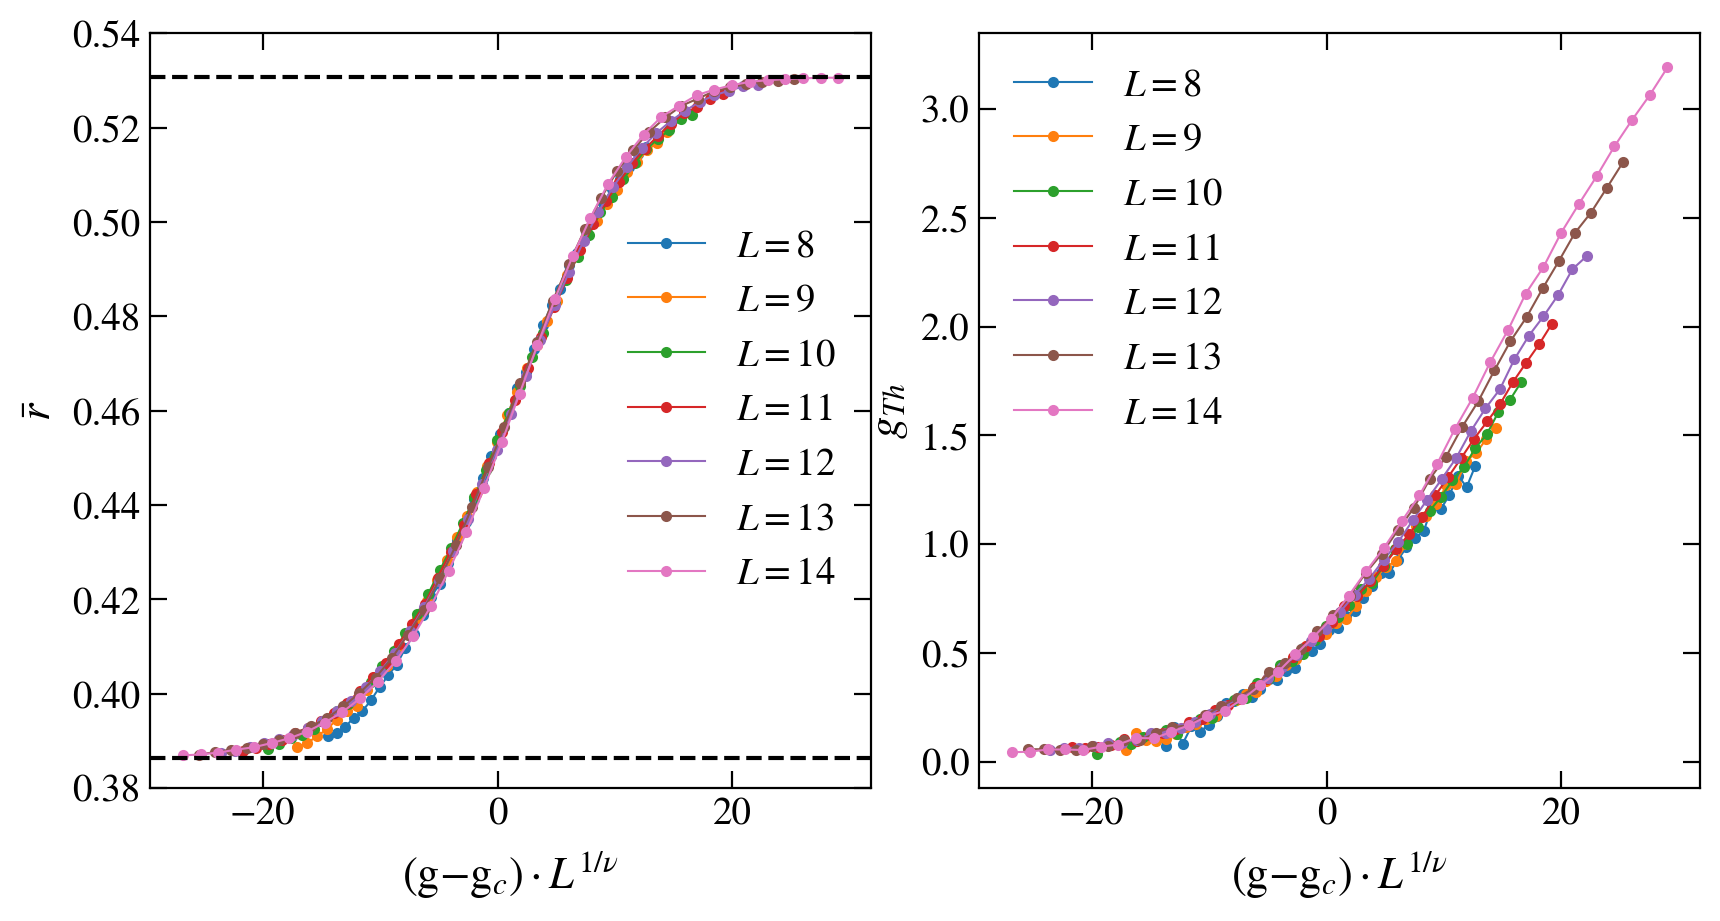

In [177]:
L=14
g=1

g_vals = np.linspace(0.05, 2.0, 40)

sub_sizes = np.arange(0, L+1)
fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 200)

sizes = np.arange(8, 15, 1)

rescale = 0
r_min = 0.32
nu = 0.5
frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu

folder_base = f'./collected data/'
folder = folder_base + base_dir[3:] + f"nu={nu}/"
os.makedirs(folder_base, exist_ok=True)
os.makedirs(folder, exist_ok=True)

xlab = r"$g$"
    

critfun='free'
ansatz='classic'

rescale_fun = cost.resc_functions_dict[ansatz]
critical_fun = cost.crit_functions_dict[critfun]
xlab = r"$%s$"%cost.scale_ansatz_label[ansatz](xlab)

perturbation = []
gap_ratio = []
for L in sizes:
    # L = L_total - N
    name = f"./collected data/results/nu={nu}/" + f'_L={L}.hdf5'
    if os.path.exists(name):
        with h5py.File(name, "r") as file:
            perturbation.append( np.array(file.get('perturbation')))
            gap_ratio.append(np.array(file.get('gap_ratio')))
    else:
        print(name)
perturbation = np.array(perturbation)
gap_ratio    = np.array(gap_ratio)

thouless_cond = []
for ii_L, L in enumerate(sizes):
    # L = L_total - N
    name = f"./thouless time/" + f'_L={L}.hdf5'
    if os.path.exists(name):
        with h5py.File(name, "r") as file:
            tH      = np.array(file.get('heisenberg time'))
            t_Th    = np.array(file.get('thouless time'))
            thouless_cond.append( np.log(1. / t_Th) )
    else:
        print(name)
thouless_cond   = np.array(thouless_cond)

filename = f"CriticalParameters/GapRatio_critfun=%s_ansatz=%s.hdf5"%(critfun, ansatz)
if exists(filename):
    with h5py.File(filename, "r") as file:
        crit_pars   = np.transpose(np.array(file.get('crit_pars')))
        crit_exp    = np.array(file.get('crit exp'))
        CF          = np.array(file.get('costfun'))
else:
    print(filename)
criticals = np.zeros( (len(crit_pars)) )
for ii in range(len(crit_pars)):
    criticals[ii] = np.median(crit_pars[ii])

for ii, L in enumerate(sizes):
    axis[0].plot(rescale_fun(perturbation[ii], sizes, ii, critical_fun, np.median(crit_exp), *criticals), gap_ratio[ii], marker='o', markersize=3, lw=0.75, label=r"$L=%d$"%L)
    
# filename = f"CriticalParameters/Thouless_critfun=%s_ansatz=%s.hdf5"%(critfun, ansatz)
# if exists(filename):
#     with h5py.File(filename, "r") as file:
#         crit_pars   = np.transpose(np.array(file.get('crit_pars')))
#         crit_exp    = np.array(file.get('crit exp'))
#         CF          = np.array(file.get('costfun'))
# else:
#     print(filename)
# for ii in range(len(crit_pars)):
#     criticals[ii] = np.median(crit_pars[ii])
for ii, L in enumerate(sizes):
    axis[1].plot(rescale_fun(perturbation[ii], sizes, ii, critical_fun, np.median(crit_exp), *criticals), thouless_cond[ii], marker='o', markersize=3, lw=0.75, label=r"$L=%d$"%L)
    # axis[1].plot(perturbation[ii], thouless_cond[ii], marker='o', markersize=3, lw=0.75, label=r"$L=%d$"%L)
    # axis[idx1].plot(rescale_fun(disorder[ii], sizes, ii, critical_fun, par, *crit_pars), gaps[ii], ls='--', marker='o', label=r"$L=%d$"%(L))

axis[0].axhline(y=0.3863, ls='--', color='black')
axis[0].axhline(y=0.5307, ls='--', color='black')

axis[0].set_ylim(0.38,0.54)
# axis[1][idx1].set_ylim(0.0,1.0)
# axis[0][idx1].set_xlim(-1e5, 10)
# axis[1][idx1].set_xlim(-1e5, 10)

    
# if not config_disorder: axis[idx1].set_xlim(0, None)
#         # axis[idx2][idx1].set_xlim(0.0,2)

fig_help.set_plot_elements(axis[0], ylabel=r"$\bar{r}$", xlabel=xlab, font_size=14, set_legend=True)
fig_help.set_plot_elements(axis[1], ylabel=r"$g_{Th}$", xlabel=xlab, font_size=14, set_legend=True)


fig.subplots_adjust(wspace = 0.15, hspace=0.15)

## BETA FUNCTION

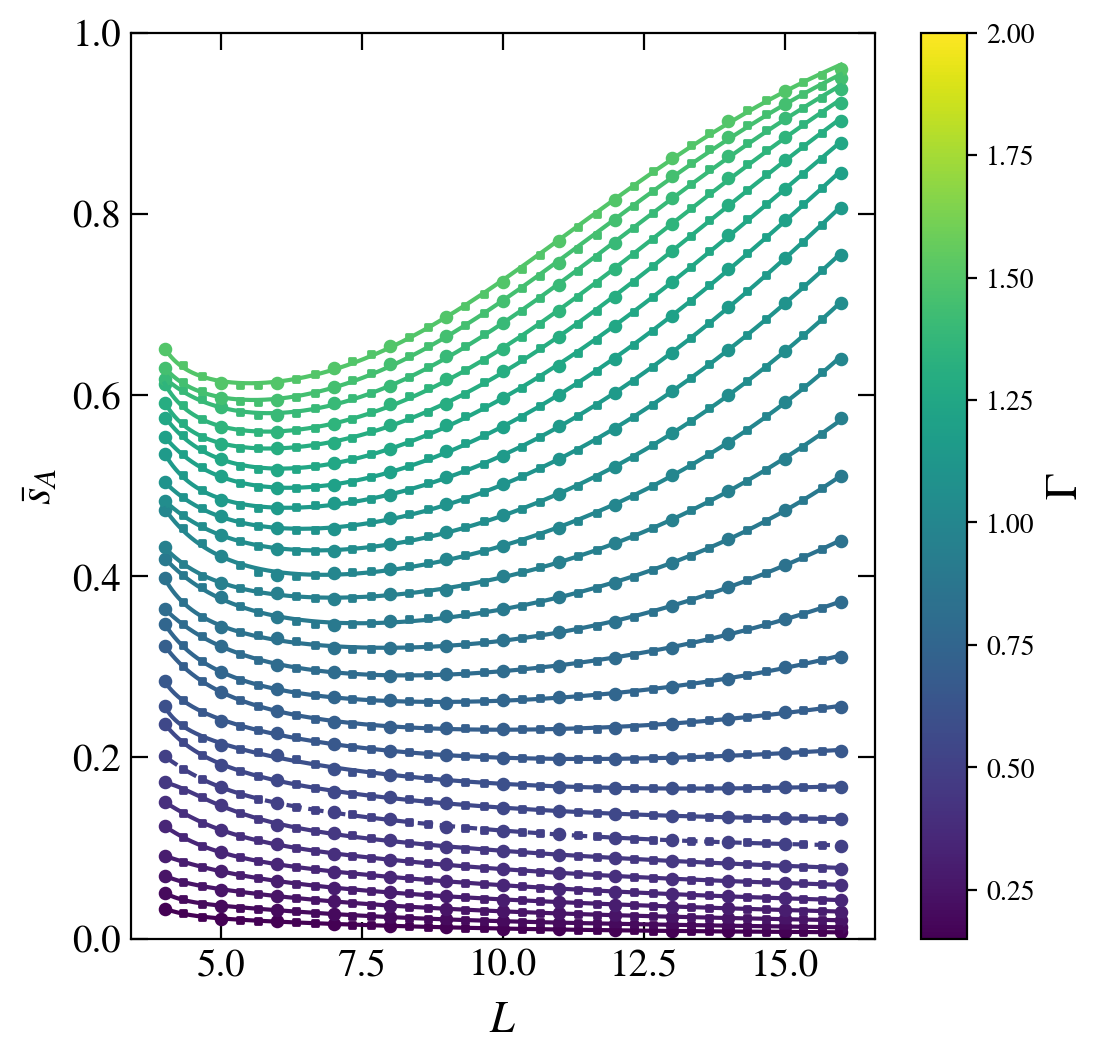

In [41]:
L=15
J=1

options = ['s', 'r', 'D1']
sizes = np.arange(4, 17, 1)

interpolate = 1

p = 1       # number of last spins
nu = 500

option = 's'
if option not in options:
    print(option, "Not found! Using sA instead")
    print(1/0)
xlabs = {'s': r"$\bar{s}_A$", 'r': r"$\bar{r}$", 'D1': r"$\bar{D}_1$"}

plot_fractal = (option == 'D1')


frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu

folder_base = f'./collected data/'
folder = folder_base + base_dir[3:] + f"nu={nu}/"
os.makedirs(folder_base, exist_ok=True)
os.makedirs(folder, exist_ok=True)

    
xlab = r"$L$"

def pade_fun(x, c1, c2, c3, d1, d2, d3):
    # return c1 * np.arctan(c2 * x - d1)
    return (x**3 + c1*x**2 + c2*x + c3) / (x**3 + d1*x**2 + d2 * x + d3)
    # return (x**2 + c1 * x + c2) / (x**2 + d1 * x + d2)

def other_fit(x, c1, c2, c3, c4, c5, c6):
    # return c1 / x**3 + c2 / x**2 + c3 / x**1 + c4
    return c1 / x**3 + c2 / x**2 + c3 / x**1 + c4 + c5/x**4 + c6 / x**5

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(6,6), dpi = 200)

g_crit = 0.5

interaction = []
S = []
Sinfo = []
gaps = []
for L in sizes:
    LA = 2

    name_out = folder + f'_L={L}.hdf5'

    if exists(name_out):
        with h5py.File(name_out, "r") as file:
            g_vals       = np.array(file.get('perturbation'))
            gap_ratio    = np.array(file.get('gap_ratio'))
            entropy      = np.array(file.get('entropy'))
            entropy_site = np.array(file.get('single_site_entropy'))
            Sinfo_vN     = np.array(file.get('vN info entropy'))
    else:
        print(name_out)

    entropy = entropy[LA] / page(LA, L-LA)
    interaction.append(g_vals)
    S.append(entropy)
    Sinfo.append(Sinfo_vN)
    gaps.append((gap_ratio - 0.3863) / (0.5307 - 0.3863))
    

# norm is a class which, when called, can normalize data into the
# [0.0, 1.0] interval.
norm = matplotlib.colors.Normalize(
    vmin=np.min(g_vals),
    vmax=np.max(g_vals))

# choose a colormap
# c_m = matplotlib.cm.cool

# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap='viridis', norm=norm)
s_m.set_array([])


if option == 's': ydata = S
elif option == 'D1': ydata = Sinfo
elif option == 'r': ydata = gaps
else:
    print("Not chosen any data")
    
ydata = np.transpose( np.array(ydata) )

beta_0 = np.zeros( (g_vals.size) )
new_xx = np.zeros( (g_vals.size) )

for ii_a, g in enumerate(g_vals):

    xx = sizes
    yy = ydata[ii_a]
    if any(np.isnan(yy)): continue
    if plot_fractal:
        D1 = np.diff(yy) / np.log(2)
        yy = ( D1[:-1] + D1[1:] ) / 2.0
        xx = sizes[1:-1]
        # if interpolate:
        #     spl = make_spline(sizes, ydata[ii_a])
        #     xx = np.linspace(sizes[0], sizes[-1], 20)
        #     yy = spl(xx)
        #     D1 = np.gradient(yy, xx[1] - xx[0]) / np.log(2)
        #     yy = D1 if idx1 == 3 and J != 1 else yy
    # print(xx, yy)  
    axis.scatter(xx, yy, marker='o', s=15, color=s_m.to_rgba(g))
    if interpolate:
        # axis[idx1].scatter(sizes, ydata[ii_a], marker='o', s=10, color=s_m.to_rgba(alfa))
        spl = make_spline(xx, yy)
        xx = np.linspace(xx[0], xx[-1], xx.size + (xx.size-1) * 2)
        yy = spl(xx)
        axis.scatter(xx, yy, marker='s', s=5, color=s_m.to_rgba(g))
    
    my_fit = pade_fun if g > g_crit else other_fit
    try:
        # xx = xx - N
        pars, pconv = fit(my_fit,
                        xdata = xx,
                        ydata = yy, maxfev = 10000)
        # print(J, g, fit_info['fvec'])
        dense_sizes = np.linspace(xx[0], xx[-1], 10000)
        axis.plot(dense_sizes, my_fit(dense_sizes, *pars), lw=1.5, color=s_m.to_rgba(g), ls = '--' if g == g_crit else '-')
    except RuntimeError:
        print(alfa)
    

# axis[idx1].set_ylim(0.97*min(ydata[alfa <= alfa_crit + dalfa or alfa >= alfa_crit - dalfa].flatten()), 1.0)
fig_help.set_plot_elements(axis, ylabel=xlabs[option], xlabel=xlab, font_size=14, set_legend=False, xscale='linear', yscale='linear', ylim=(0, 1))

cbar = fig.colorbar(s_m, ax=axis, orientation='vertical')
cbar.set_label(r"$\Gamma$", fontsize=16)


No handles with labels found to put in legend.


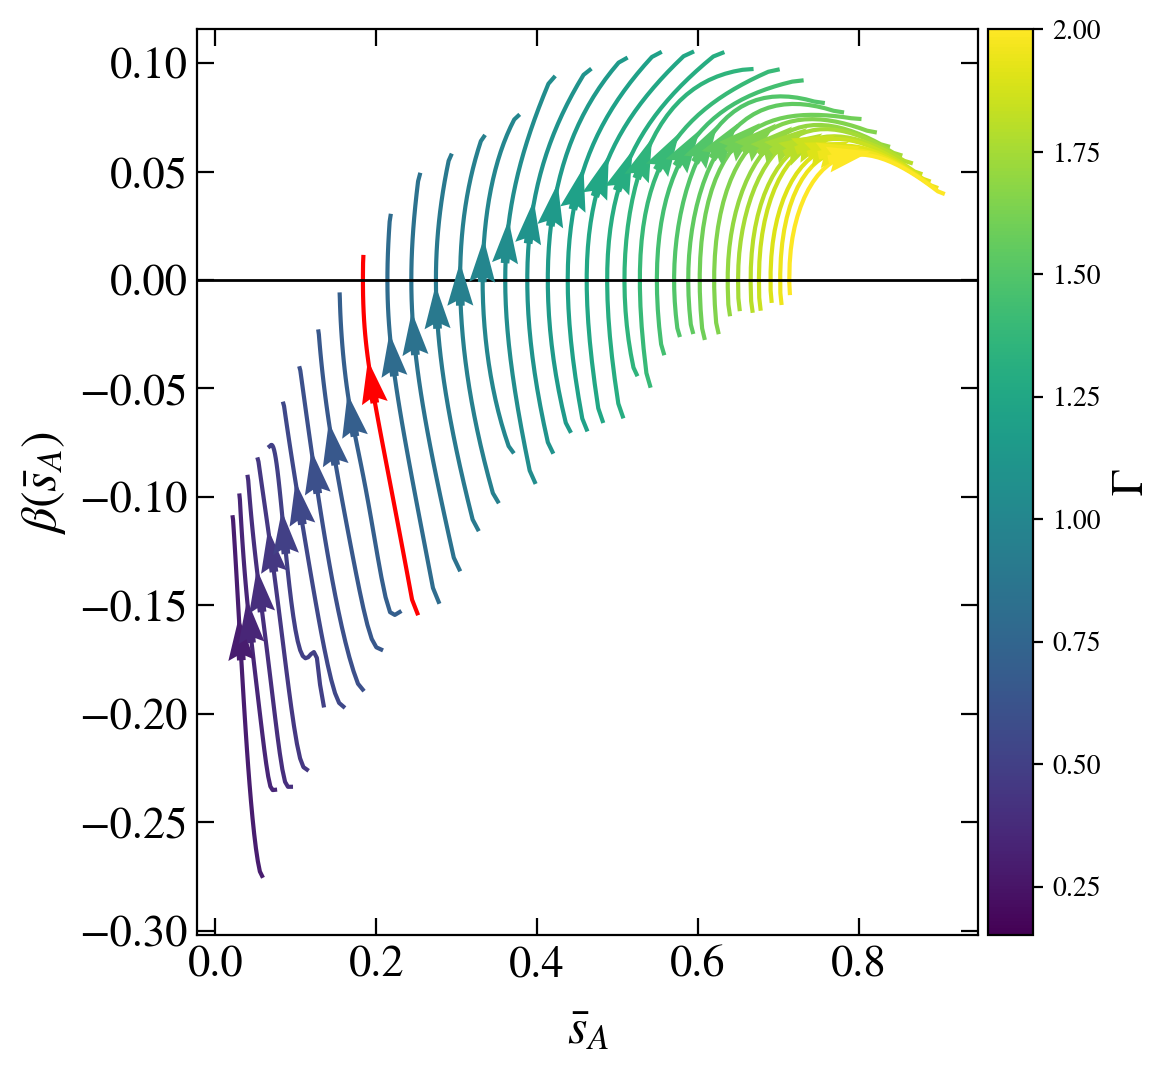

In [50]:
L=15
J=1

options = ['s', 'r', 'D1']
nu = 500
use_fit = 1
interpolate = 1
bin_size = 5
use_area_collapse = 0
option = 's'

if option not in options:
    print(option, "Not found! Using sA instead")
    print(1/0)
xlabs = {'s': r"$\bar{s}_A$", 'r': r"$\bar{r}$", 'D1': r"$\bar{D}_1$"}

plot_fractal = (option == 'D1')


frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu

folder_base = f'./collected data/'
folder = folder_base + base_dir[3:] + f"nu={nu}/"
os.makedirs(folder_base, exist_ok=True)
os.makedirs(folder, exist_ok=True)

    
xlab = r"$L$"

def pade_fun(x, c1, c2, c3, d1, d2, d3):
    # return c1 * np.arctan(c2 * x - d1)
    return (x**3 + c1*x**2 + c2*x + c3) / (x**3 + d1*x**2 + d2 * x + d3)
    # return (x**2 + c1 * x + c2) / (x**2 + d1 * x + d2)

def other_fit(x, c1, c2, c3, c4, c5, c6):
    # return c1 / x**3 + c2 / x**2 + c3 / x**1 + c4
    return c1 / x**3 + c2 / x**2 + c3 / x**1 + c4 + c5/x**4 + c6 / x**5

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(6,6), dpi = 200)
  
g_crit = 0.75
sizes = np.arange(6, 16, 2)

interaction = []
S = []
Sinfo = []
gaps = []
for L in sizes:
    LA = L//2

    name_out = folder + f'_L={L}.hdf5'

    if exists(name_out):
        with h5py.File(name_out, "r") as file:
            g_vals       = np.array(file.get('perturbation'))
            gap_ratio    = np.array(file.get('gap_ratio'))
            entropy      = np.array(file.get('entropy'))
            entropy_site = np.array(file.get('single_site_entropy'))
            Sinfo_vN     = np.array(file.get('vN info entropy'))
    else:
        print(name_out)

    entropy = entropy[LA] / page(LA, L-LA)
    interaction.append(g_vals)
    S.append(entropy)
    Sinfo.append(Sinfo_vN)
    gaps.append((gap_ratio - 0.3863) / (0.5307 - 0.3863))

# norm is a class which, when called, can normalize data into the
# [0.0, 1.0] interval.
norm = matplotlib.colors.Normalize(
    vmin=np.min(g_vals),
    vmax=np.max(g_vals))


# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap='viridis', norm=norm)
s_m.set_array([])

if option == 's': ydata = S
elif option == 'D1': ydata = Sinfo
elif option == 'r': ydata = gaps
else:
    print("Not chosen any data")

ydata = np.transpose( np.array(ydata) )
# print(ydata)
idx_c = 0

envelope_ydata = []
envelope_xdata = []
yax_max = -10
yax_min = 10
for ii_a, g in enumerate(g_vals):
    if g < 0.3: continue
    if g == g_crit: idx_c = ii_a
    col = 'red' if np.round(g, 2) == g_crit else s_m.to_rgba(g)
    # col = s_m.to_rgba(g)

    xx = sizes
    yy = ydata[ii_a]
    if any(np.isnan(yy)): continue
    if plot_fractal:
        D1 = np.diff(yy) / np.log(2)
        yy = ( D1[:-1] + D1[1:] ) / 2.0
        xx = sizes[1:-1]
    
    if interpolate:
        # axis[idx1].scatter(sizes, ydata[ii_a], marker='o', s=10, color=s_m.to_rgba(alfa))
        spl = make_spline(xx, yy)
        xx = np.linspace(xx[0], xx[-1], xx.size + (xx.size-1) * 2)
        yy = spl(xx)
    
    if not use_fit:
        if use_area_collapse: xx = np.log(xx)
        xx_beta = np.zeros( (xx.size - 1) )
        beta = np.zeros( (xx.size - 1) )
        for ii in range(xx.size - 1):
            xx_beta[ii] = yy[ii+1]
            beta[ii] = ( np.log(yy[ii+1]) - np.log(yy[ii])) / ( xx[ii+1] - xx[ii]) / (1.0 if use_area_collapse else np.log(2))
            envelope_ydata.append(beta[ii])
            envelope_xdata.append(xx_beta[ii])
        # envelope_ydata.append(beta[-1])
        # envelope_xdata.append(xx[-1])
        
        axis.plot(xx_beta, beta, marker='o', markersize=2, lw=1.5, color=col)
        if min(beta) < yax_min: yax_min = min(beta)
        if max(beta) > yax_max: yax_max = max(beta)
        i1 = xx.size // 2
        u = xx_beta[i1+1] - xx_beta[i1]
        v = beta[i1+1] - beta[i1]
        pos_x = xx_beta[i1] + u/2
        pos_y = beta[i1] + v/2
        norm = np.sqrt(u**2+v**2)

        axis.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=5, pivot="mid", color=col, lw=0)
    else:

        my_fit = pade_fun if g > g_crit else other_fit
        # print(alfa, xx, yy)
        pars, pconv = fit(my_fit,
                            xdata = xx,
                            ydata = yy, maxfev=10000)
        dense_sizes = np.arange(xx[0], xx[-1]+0.25, 0.25)
        smooth_data = my_fit(dense_sizes, *pars)
        deriv = np.gradient( np.log(smooth_data), dense_sizes[1] - dense_sizes[0] ) / (1.0 / dense_sizes if use_area_collapse else np.log(2))
        axis.plot(smooth_data, deriv, lw=1.5, color=col)
        
        if min(deriv) < yax_min: yax_min = min(deriv)
        if max(deriv) > yax_max: yax_max = max(deriv)
        # spline = InterpolateSpline(sizes, ydata[ii_a], k=5, s=0)
        # spl_deriv = spline.derivative(n=1)
        # aaaa = np.linspace(sizes[0], sizes[-1], 100)
        # smooth_data = spline(aaaa)
        # deriv = spl_deriv(aaaa)
        
        envelope_ydata = [*envelope_ydata, *deriv]
        envelope_xdata = [*envelope_xdata, *smooth_data[smooth_data > 0]]
        # envelope_ydata = [*envelope_ydata, deriv[-1]]
        # envelope_xdata = [*envelope_xdata, smooth_data[-1]]

        i1 = smooth_data.size // 2
        u = smooth_data[i1+1] - smooth_data[i1]
        v = deriv[i1+1] - deriv[i1]
        pos_x = smooth_data[i1] + u/2
        pos_y = deriv[i1] + v/2
        norm = np.sqrt(u**2+v**2)
    
        axis.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=5, pivot="mid", 
                            linewidth=0, width=0.02, headwidth=3, color=col, lw=0)
        
        # dense_sizes = np.arange(xx[-1], 1000, 0.1)
        # smooth_data = my_fit(dense_sizes, *pars)
        # deriv = np.gradient( np.log(smooth_data), dense_sizes[1] - dense_sizes[0] ) / (1.0 / dense_sizes if use_area_collapse else np.log(2))
        # axis[idx1].plot(smooth_data, deriv, lw=1.5, color=col, ls=':')
        
# sorting X and Y data according to increasing X
permut = np.argsort( np.array(envelope_xdata) )
envelope_ydata = np.array(envelope_ydata)[permut]
envelope_xdata = np.array(envelope_xdata)[permut]

size = len(envelope_xdata)
envelope = np.zeros( (size // bin_size) )
sp_binned = np.zeros( (size // bin_size) )

# Finding maximum Y in each bin of 20 points of interpolated data
for k in range(envelope.size):
    idx_r = (k+1) * bin_size if k < envelope.size-1 else -1
    idx = np.argmax(envelope_ydata[k * bin_size : idx_r])
    envelope[k]  = envelope_ydata[k * bin_size : idx_r][idx]
    sp_binned[k] = envelope_xdata[k * bin_size : idx_r][idx]
# xxx = envelope_xdata
# envelope = envelope_ydata
# axis[idx1].plot(xxx, envelope, lw=2, color='k', ls='--')
# print(envelope)
def envelope_polynomial(x, c1, c2, c3, c4, c5):#, c6, c7):#, c8):#, c9):#, c10):
    return c1 * (x) + c2 * (x)**2 + c3 * (x)**3 + c4 * (x)**4 + c5 * (x)**5#+ c6 * (x)**6 + c7 * (x)**7# + c8 * (x-1)**8# + c9 * (x-1)**9# + c10 * (x-1)**10
pars, pconv = fit(envelope_polynomial,
                    xdata = sp_binned,
                    ydata = envelope)

sp = np.linspace(min(envelope_xdata.flatten()), max(envelope_xdata.flatten()), 10000)
envelope_fitted = envelope_polynomial(sp, *pars)
# axis[idx1].plot(sp, envelope_fitted, lw=2, color='k', ls='--', label=r"$\tilde{\beta}$" if use_area_collapse else r"${\beta}$")

# Sc_idx = np.argwhere(np.abs(envelope_fitted) < 1e-2)[0][0]
# Sc = sp[Sc_idx]
# print(Sc_idx)
# print(Sc_idx, sp[Sc_idx])
# def linearize_at_transition(x, a, Sc):
#     return a * (x - Sc)
# # print(Sc_idx, envelope[Sc_idx - 20 : Sc_idx + 20])
# pars, pconv = fit(linearize_at_transition,
#                     xdata = sp[Sc_idx - 100 : Sc_idx + 100],
#                     ydata = envelope_fitted[Sc_idx - 100 : Sc_idx + 100])
# nu_exp = 1./ (pars[0] * pars[1])
# Sc = pars[1]
# print(*pars, "------", nu_exp, Sc)
# axis[idx1].plot(sp, linearize_at_transition(sp, *pars), lw=1, color='gray', ls='-')

axis.set_ylim(1.1*yax_min, 1.1*yax_max)

axis.axhline(y=0, ls='-', c='k', lw=1)
xlab = xlabs[option]
ylab = r"$\tilde{\beta}($" + xlab + "$)$" if use_area_collapse else r"${\beta}($" + xlab + "$)$"
fig_help.set_plot_elements(axis, xlabel=xlab, ylabel=ylab, font_size=16, set_legend=True, xscale='linear')
cbar = fig.colorbar(s_m, ax=axis, orientation='vertical', pad=0.01)
cbar.set_label(r"$\Gamma$", fontsize=16)


In [3]:
0.33 / 40

0.00825

## SPECTRAL FORM FACTOR

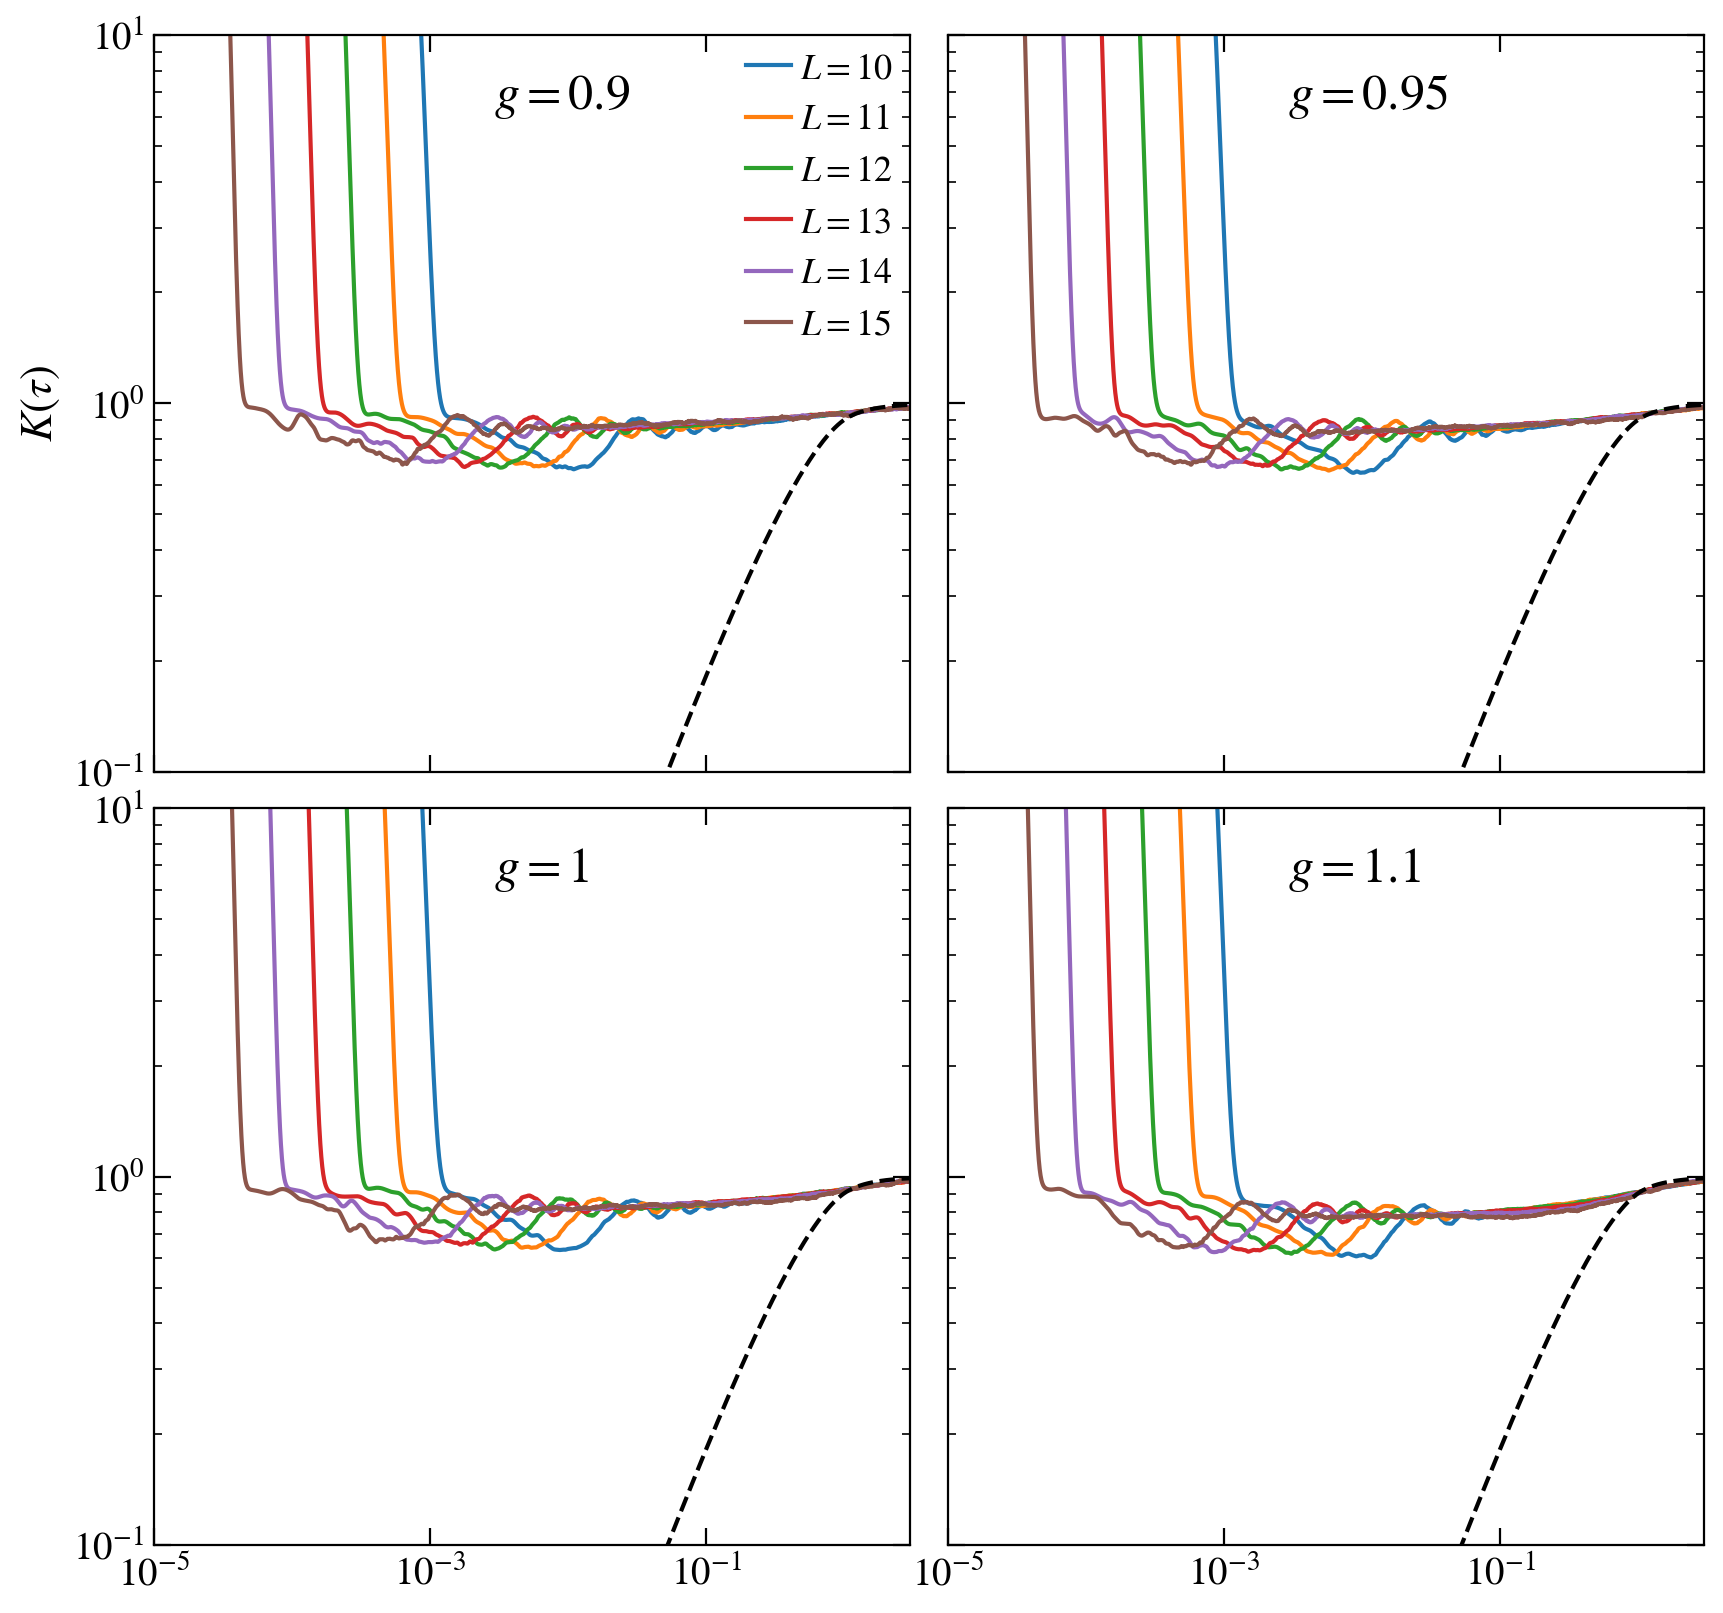

In [60]:
L=15
g=1.0

sizes = np.arange(10, 16, 1)

bucket = 50
raw = 1
running_mean = 1
eta = 0.1

g_vals = [5., 5.5, 6.]

fig, axis = plt.subplots( nrows=2, ncols=2, figsize=(10,10), dpi = 200, sharex=True, sharey=True)
axis = axis.flatten()

for row in range(1):
        g_vals = [0.9, 0.95, 1, 1.1]
        # if row == 0:    g_vals = [0.6, 0.65, 0.7]
        # elif row == 1:    g_vals = [0.75, 0.8, 0.85]
        # elif row == 2:    g_vals = [1.5, 1.55, 1.8]
        # if row == 0:    g_vals = [0.5, 0.8, 1.]
        # elif row == 1:    g_vals = [1.2, 1.5, 1.8]
        # elif row == 2:    g_vals = [2, 3, 4.0]

        for ii_g, g in enumerate(g_vals):
            for L in sizes:
                name = base_dir + 'SpectralFormFactor/' + info(L=L, g=g, ext='.hdf5')
                if exists(name):
                    with h5py.File(name, "r") as file:
                        tHtyp = np.array(file.get('tH_typ'))# / (2 * np.pi)
                        times = np.array(file.get('times_fold')) / tHtyp if raw else np.array(file.get('times'))
                        sff = np.array(file.get('sff_raw' if raw else 'sff_eta=%g'%eta))
                        try:
                            if sff.shape == (1, 5000):                             
                                times = times[0]
                                sff = sff[0]
                            if running_mean: sff = tools.remove_fluctuations(sff, bucket)
                            
                            sff = sff[bucket // 2 : -bucket // 2]
                            times = times[bucket // 2 : -bucket // 2]
                            axis[ii_g].plot(times, sff, label=r"$L=%d$"%L)
                        except IndexError:
                             print(name)
                else:
                    print(name)
            axis[ii_g].plot(times, goe.spectral_form_factor(times), ls='--', c='k')

            

            fig_help.set_plot_elements(axis[ii_g], ylabel=r"$K(\tau)$" if ii_g == 0 else "", xlabel=r"$\tau$" if row == 2 else "", font_size=14, set_legend=False, xscale='log', yscale='log', ylim=(1e-1,1e1), xlim=(1e-5, 3))
            # axis[ii_g].set_title(r"$g=%g$"%g)
            axis[ii_g].annotate(r"$g=%g$"%g, fontsize=18, xy=(0.45, 0.9), xycoords='axes fraction')
# axis[1][1].axhline(y=0.48, ls='--', c='k')
# axis[1][2].axhline(y=0.44, ls='--', c='k')
# axis[2][0].axhline(y=0.4, ls='--', c='k')
fig_help.set_legend(axis[0], loc = 'upper right', fontsize=13)

# fig_help.set_plot_elements(axis[1], ylabel=r"$\left\langle\bar{S}_A^{\ell}\right\rangle$", xlabel=rescale_func_names[iabc], font_size=14, set_legend=False)


fig.subplots_adjust(wspace = 0.05, hspace=0.05)
# plt.savefig("Fig_sff.pdf", bbox_inches = 'tight', pad_inches=0.02)
# plt.savefig("Fig_sff.png", bbox_inches = 'tight', pad_inches=0.02)

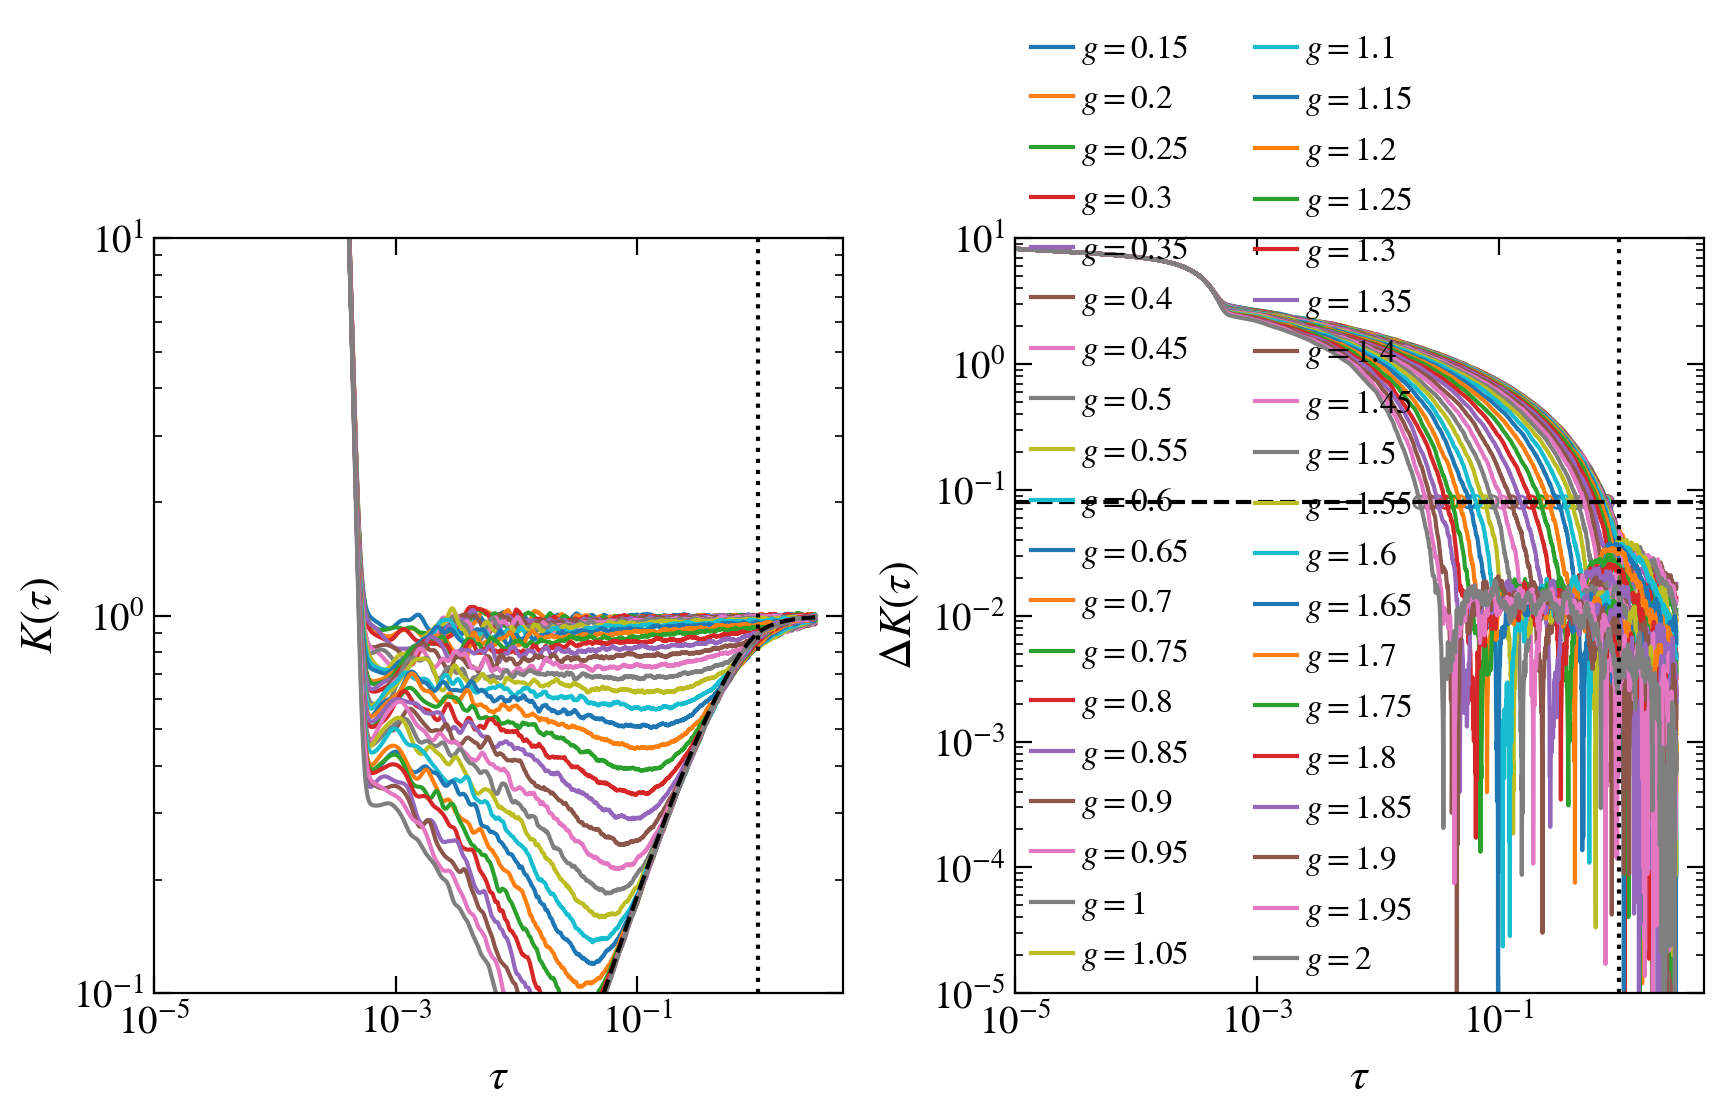

In [29]:
L=15
g=0.85

sizes = np.arange(8, 15, 1)
g_vals = np.linspace(0.15, 2., 38)

bucket = 50
folded = 0
running_mean = 1
eta=0.1
epsilon=0.08


fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 200, sharex=True)

for ii_g, g in enumerate(g_vals):
# for ii_L, L in enumerate(sizes):
    name = base_dir + 'SpectralFormFactor/' + info(L=L, g=g, ext='.hdf5')
    if exists(name):
        with h5py.File(name, "r") as file:
            tHtyp = np.array(file.get('tH_typ'))[0] / (2*np.pi)
            times = np.array(file.get('times_fold')) / tHtyp if folded else np.array(file.get('times'))
            sff = np.array(file.get('sff_folded' if folded else "sff_eta=%.1f"%eta))
            try:
                if sff.shape == (1, 5000):
                    sff = sff[0]
                    times = times[0]
                if running_mean: 
                    sff = tools.remove_fluctuations(sff, bucket)
                    sff = sff[bucket // 2 : -bucket // 2]
                    times = times[bucket // 2 : -bucket // 2]
                axis[0].plot(times, sff)

                sff = np.abs( np.log10(sff / goe.spectral_form_factor(times)) )
                idx = (np.abs(sff - epsilon)).argmin()

                pl = axis[1].plot(times, sff, label=r"$g=%g$"%g)
                axis[1].scatter(times[idx], sff[idx], color=pl[0].get_color(), facecolor='None', s=20)
            except TypeError:
                print("Old file", name)
    else:
        print(name)
axis[0].plot(times, goe.spectral_form_factor(times), ls='--', c='k')
axis[1].axhline(y=epsilon, ls='--', c='k')

axis[0].axvline(x=1, ls=':', c='k')
axis[1].axvline(x=1, ls=':', c='k')
fig_help.set_plot_elements(axis[0], ylabel=r"$K(\tau)$", xlabel=r"$\tau$", font_size=14, set_legend=False, xscale='log', yscale='log', ylim=(1e-1,1e1), xlim=(1e-5, 5))
fig_help.set_plot_elements(axis[1], ylabel=r"$\Delta K(\tau)$", xlabel=r"$\tau$", font_size=14, set_legend=False, xscale='log', yscale='log', ylim=(1e-5,1e1), xlim=(1e-5, 5))
fig_help.set_legend(axis[1], loc = 'lower left', fontsize=12, ncol=2)

# fig_help.set_plot_elements(axis[1], ylabel=r"$\left\langle\bar{S}_A^{\ell}\right\rangle$", xlabel=rescale_func_names[iabc], font_size=14, set_legend=False)


fig.subplots_adjust(wspace = 0.25, hspace=0.2)

In [28]:
L_total=15
N=3

J=1.0

sizes = np.arange(8, 16, 1)

bucket = 50
folded = 0
running_mean = 1
epsilon=0.08
eta=0.1

g_vals = np.linspace(0.15, 2., 38)

folder = f'./thouless time/'
os.makedirs(folder, exist_ok=True)

for L in sizes:
    t_Th    = np.zeros((g_vals.size))
    tH      = np.zeros((g_vals.size))
    tH_typ  = np.zeros((g_vals.size))
    name_out = folder + f'_L={L}.hdf5'
    for ii_g, g in enumerate(g_vals):
        name = base_dir + 'SpectralFormFactor/' + info(L=L, g=g, ext='.hdf5')
        if exists(name):
            with h5py.File(name, "r") as file:
                tH[ii_g]     = np.array(file.get('tH'))[0]
                tH_typ[ii_g] = np.array(file.get('tH_typ'))[0]
                tHtyp = np.array(file.get('tH_typ'))[0]
                times = np.array(file.get('times_fold')) * (2*np.pi) / tHtyp if folded else np.array(file.get('times'))
                sff = np.array(file.get('sff_folded' if folded else "sff_eta=%.1f"%eta))
                try:
                    if sff.shape == (1, 5000):
                        sff = sff[0]
                        times = times[0]
                    sff = tools.remove_fluctuations(sff, bucket)
                    sff = sff[bucket // 2 : -bucket // 2]
                    times = times[bucket // 2 : -bucket // 2]
                    sff = np.abs( np.log10(sff / goe.spectral_form_factor(times)) )
                    idx = (np.abs(sff - epsilon)).argmin()
                    
                    t_Th[ii_g] = times[idx]
                except TypeError:
                    t_Th[ii_g] = np.nan
                    print("Old file", name)
        else:
            print(name)
    hf = h5py.File(name_out, 'w')
    hf.create_dataset('perturbation',            g_vals.shape,  data = g_vals)
    hf.create_dataset('thouless time',           t_Th.shape,    data = t_Th)
    hf.create_dataset('heisenberg time',         tH.shape,      data = tH)
    hf.create_dataset('typical heisenberg time', tH_typ.shape,  data = tH_typ)
    hf.close()


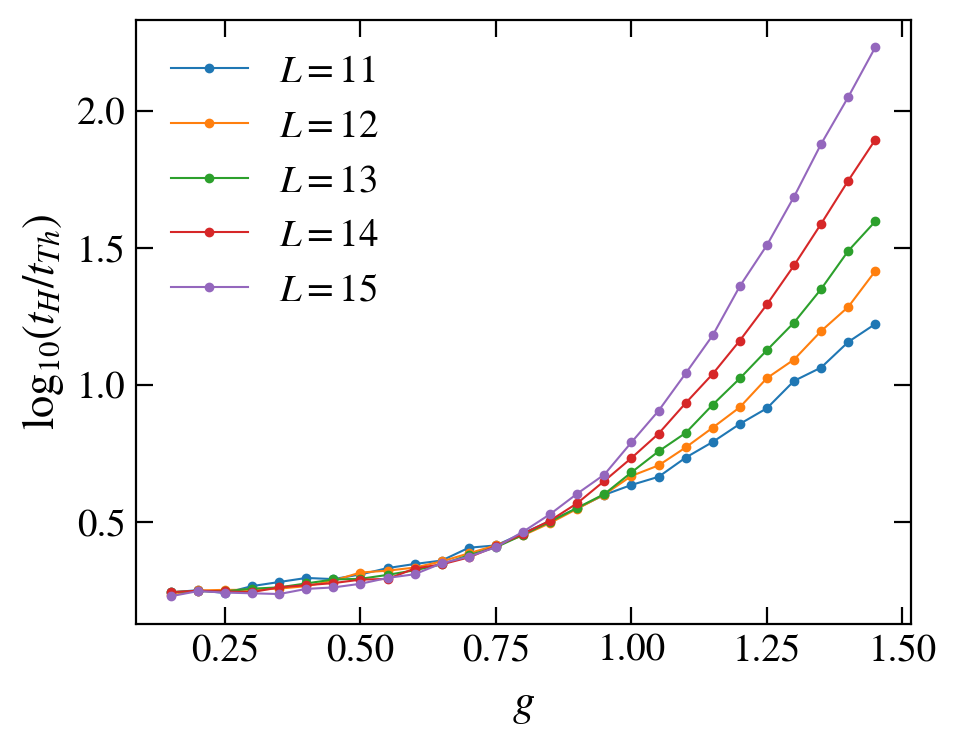

In [43]:
L=14
g=1

sizes = np.arange(11, 16, 1)

folder = f'./thouless time/'
os.makedirs(folder, exist_ok=True)

heisenberg_time = []
thouless_time = []
perturbation = []
for L in sizes:
    t_Th    = None
    tH      = None
    tH_typ  = None
    name_out = folder + f'_L={L}.hdf5'
    if exists(name_out):
        with h5py.File(name_out, "r") as file:
            g_vals  = np.array(file.get('perturbation'))
            tH      = np.array(file.get('heisenberg time'))[g_vals < 1.5]
            tH_typ  = np.array(file.get('typical heisenberg time'))[g_vals < 1.5]
            t_Th    = np.array(file.get('thouless time'))[g_vals < 1.5]
            g_vals  = g_vals[[g_vals < 1.5]]
    else:
        print(name_out)
    
    thouless_time.append(tH * t_Th)
    perturbation.append(g_vals)
    heisenberg_time.append(tH)

thouless_time = np.array(thouless_time)
heisenberg_time = np.array(heisenberg_time)
thouless_cond = np.log(heisenberg_time / thouless_time)

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(5,4), dpi = 200)
# fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)

for ii_L, L in enumerate(sizes):
    lab = r"$L=%g$"%(L)
    axis.plot(perturbation[ii_L], thouless_cond[ii_L], marker='o', markersize=2.5, label=lab, lw=0.75)
    
# axis.plot(sizes, heisenberg_time[-1], color='k', ls='-.')
fig_help.set_plot_elements(axis, ylabel=r"$\log_{10}(t_H/t_{Th})$", xlabel=r"$g$", font_size=14, set_legend=True, xscale='linear', yscale='linear')#), ylim=(3e1, 3e5))

# plt.savefig("plots/Fig2.pdf", bbox_inches = 'tight', pad_inches=0.02)
# plt.savefig("plots/Fig2.png", bbox_inches = 'tight', pad_inches=0.02)

29014 	 1.5597154511401072 [1.27598761 1.23425059 1.18109735 1.12919283]


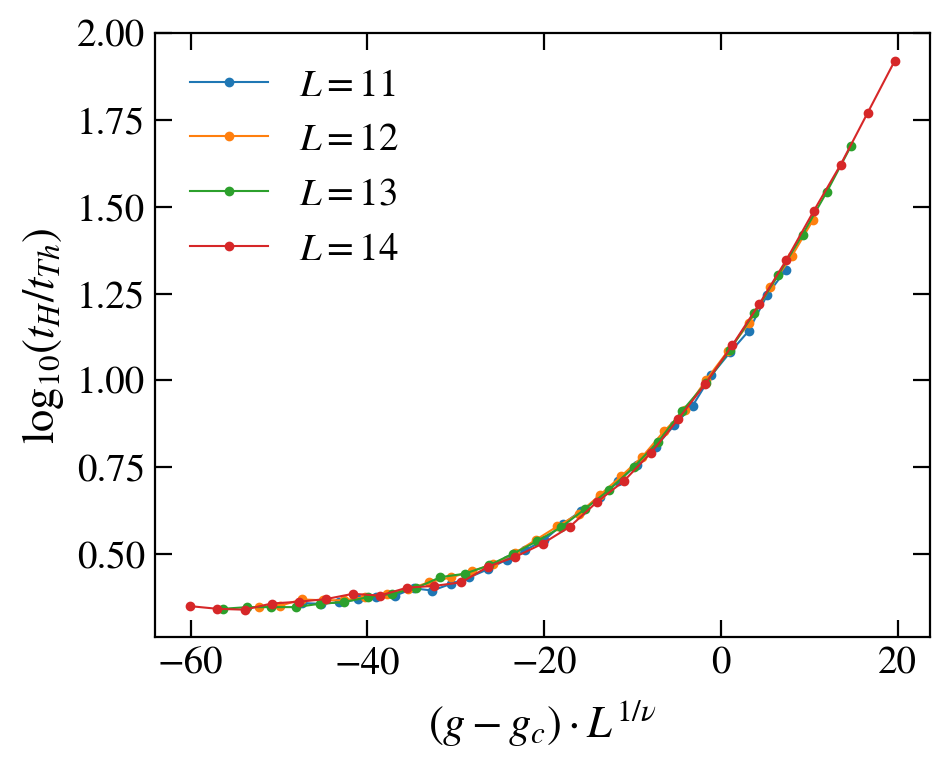

In [4]:
L=14
g=1

sizes = np.arange(11, 15, 1)

folder = f'./thouless time/'
os.makedirs(folder, exist_ok=True)

heisenberg_time = []
thouless_time = []
perturbation = []
for L in sizes:
    t_Th    = None
    tH      = None
    tH_typ  = None
    name_out = folder + f'_L={L}.hdf5'
    if exists(name_out):
        with h5py.File(name_out, "r") as file:
            g_vals  = np.array(file.get('perturbation'))
            tH      = np.array(file.get('heisenberg time'))[g_vals < 1.5]
            tH_typ  = np.array(file.get('typical heisenberg time'))[g_vals < 1.5]
            t_Th    = np.array(file.get('thouless time'))[g_vals < 1.5]
            g_vals  = g_vals[[g_vals < 1.5]]
    else:
        print(name_out)
    
    thouless_time.append(tH_typ * t_Th)
    perturbation.append(g_vals)
    heisenberg_time.append(tH_typ)

thouless_time = np.array(thouless_time)
heisenberg_time = np.array(heisenberg_time)
thouless_cond = np.log(heisenberg_time / thouless_time)

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(5,4), dpi = 200)
# fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)

num_realis = 1
nu = 0
crit_pars= np.zeros(sizes.shape)
for _ in range(num_realis):
    _seed = random.randint(1, 100000)
    par, _crit_pars, costfun, status = cost.get_crit_points(x=np.array(perturbation), y=np.array(thouless_cond), vals=sizes, crit_fun='free', scaling_ansatz='classic', seed=_seed)
    print(_seed, "\t", par, _crit_pars)
    crit_pars += np.array(_crit_pars)
    nu += par

crit_pars /= num_realis
nu /= crit_pars

scaling_ansatz = cost.resc_functions_dict['classic']
critical_fun = cost.crit_functions_dict['free']
xlab = r"$%s$"%cost.scale_ansatz_label['classic']('g')

for ii_L, L in enumerate(sizes):
    lab = r"$L=%g$"%(L)
    axis.plot(scaling_ansatz(perturbation[ii_L], sizes, ii_L, critical_fun, par, *crit_pars), thouless_cond[ii_L], marker='o', markersize=2.5, label=lab, lw=0.75)
    
# axis.plot(sizes, heisenberg_time[-1], color='k', ls='-.')
fig_help.set_plot_elements(axis, ylabel=r"$\log_{10}(t_H/t_{Th})$", xlabel=xlab, font_size=14, set_legend=True, xscale='linear', yscale='linear')#), ylim=(3e1, 3e5))

# plt.savefig("plots/Fig2.pdf", bbox_inches = 'tight', pad_inches=0.02)
# plt.savefig("plots/Fig2.png", bbox_inches = 'tight', pad_inches=0.02)

[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1]
0.2 1 0.2
0.30000000000000004 3 0.30000000000000004
0.4000000000000001 5 0.4
0.5000000000000001 7 0.5
0.6000000000000001 9 0.6
0.7000000000000002 11 0.7000000000000001
0.8000000000000003 13 0.8
0.9000000000000001 15 0.9
1.0000000000000002 17 1.0
1.1000000000000003 19 1.1


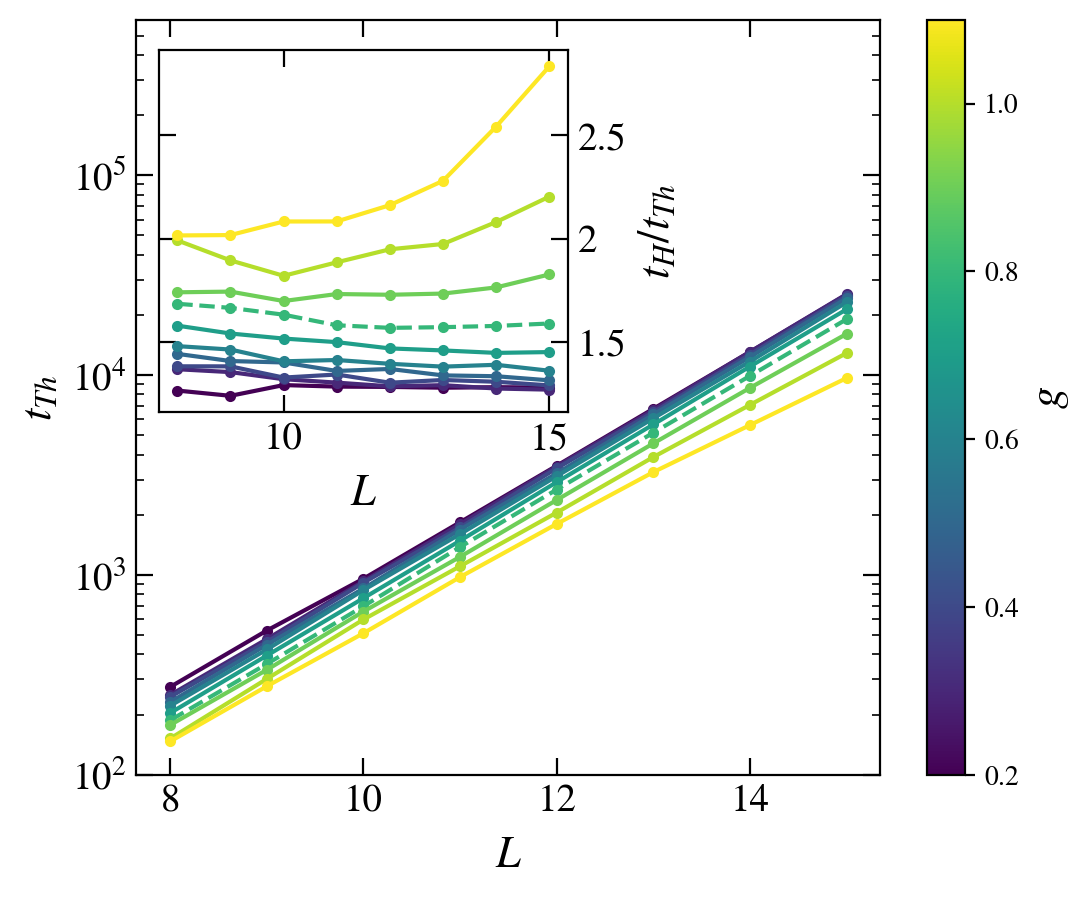

In [55]:
L=14
g=1

sizes = np.arange(8, 16, 1)

g_vals_plot = [0.5, 0.6, 0.7, 0.75, 0.8, 1, 1.1, 1.2]
g_vals_plot = np.arange(0.2, 1.15, 0.1)

g_crit = 0.8

folder = f'./thouless time/'
os.makedirs(folder, exist_ok=True)

heisenberg_time = []
thouless_time = []
disorder = []
for L in sizes:
    t_Th    = None
    tH      = None
    tH_typ  = None
    name_out = folder + f'_L={L}.hdf5'
    if exists(name_out):
        with h5py.File(name_out, "r") as file:
            g_vals  = np.array(file.get('perturbation'))
            tH      = np.array(file.get('heisenberg time'))
            tH_typ  = np.array(file.get('typical heisenberg time'))
            t_Th    = np.array(file.get('thouless time'))
    else:
        print(name_out)
    
    thouless_time.append(tH_typ * t_Th)
    disorder.append(g_vals)
    heisenberg_time.append(tH_typ)

thouless_time = np.transpose( np.array(thouless_time) )
heisenberg_time = np.transpose( np.array(heisenberg_time) )

norm = matplotlib.colors.Normalize(
        vmin=np.min(g_vals_plot),
        vmax=np.max(g_vals_plot))


# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap='viridis', norm=norm)
s_m.set_array([])

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(6,5), dpi = 200)
# fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)

inset = axis.inset_axes([0.03, 0.48, 0.55, 0.48])
print(g_vals_plot)
xi0 = []
xi1 = []
for g in g_vals_plot:
    ii_g = (np.abs(g_vals - g)).argmin()
    print(g, ii_g, g_vals[ii_g])
    is_crit = np.round(g, 2) == g_crit

    # col = 'red' if is_crit else s_m.to_rgba(g)
    col = s_m.to_rgba(g)
    lin_s = '--' if is_crit else '-'
    lab = r"$g=%g$"%g
    axis.plot(sizes, thouless_time[ii_g], marker='o', color=col, ls=lin_s, markersize=3, label=lab)
    inset.plot(sizes, heisenberg_time[ii_g] / thouless_time[ii_g], marker='o', color=col, ls=lin_s, markersize=3)
    
    pars, pconv = fit(exp_fit2,
                        xdata = sizes,
                        ydata = heisenberg_time[ii_g] / thouless_time[ii_g])
    xi0.append(pars[0])

inset.yaxis.set_label_position("right")
inset.yaxis.tick_right()
# inset.axhline(y=17.5, ls=':', c='black')

# axis.plot(sizes, heisenberg_time[-1], color='k', ls='-.')
fig_help.set_plot_elements(axis, ylabel=r"$t_{Th}$", xlabel=r"$L$", font_size=14, set_legend=False, xscale='linear', yscale='log', ylim=(1e2, 6e5))
fig_help.set_plot_elements(inset, ylabel=r"$t_H/t_{Th}$", xlabel=r"$L$", font_size=14, set_legend=False, xscale='linear', yscale='linear')
# fig_help.set_legend(axis, loc = 'upper right', fontsize=12, anchor=(1., 1.), ncol=2)
cbar = fig.colorbar(s_m)
cbar.set_label(r"$g$", fontsize=16)

# fig_help.set_plot_elements(inset, ylabel=r"$\xi$", xlabel=r"$g$", font_size=14, set_legend=False, xscale='linear', yscale='linear')

for ax in [inset]:
    ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
    ax.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))

# plt.savefig("plots/Fig2.pdf", bbox_inches = 'tight', pad_inches=0.02)
# plt.savefig("plots/Fig2.png", bbox_inches = 'tight', pad_inches=0.02)

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95]


Text(0.5, 1.0, '$\\frac{t_H}{t_{Th}}=Ae^{L/\\xi_0}\\qquad g>g_c=0.775\\qquad\\frac{t_H}{t_{Th}}=Ae^{-L/\\xi_1}$')

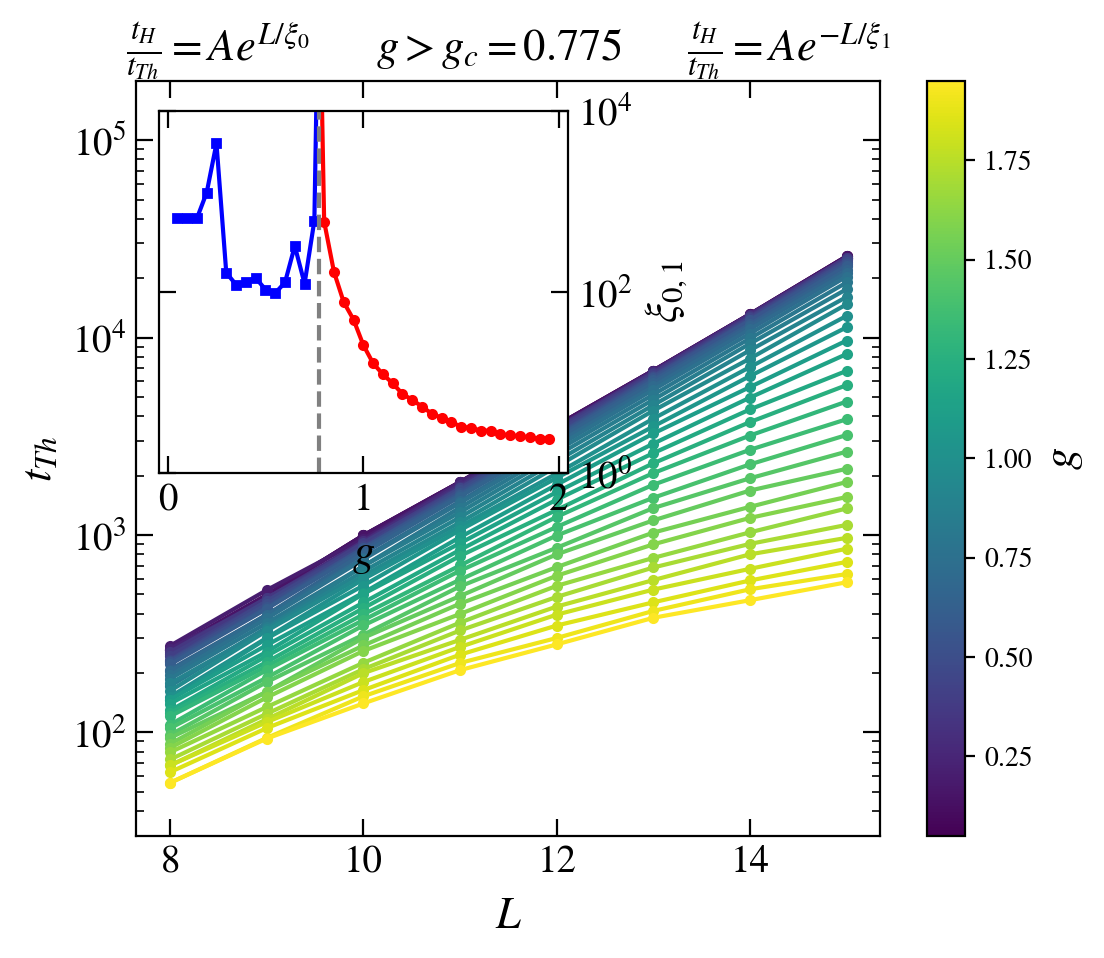

In [49]:
L=14
g=1

sizes = np.arange(8, 16, 1)

g_vals_plot = [0.5, 0.6, 0.7, 0.85, 1, 1.1, 1.2]
g_vals_plot = np.arange(0.25, 1.15, 0.1)
g_vals_plot = np.arange(0.05, 2, 0.05)

g_crit = 0.775

folder = f'./thouless time/'
os.makedirs(folder, exist_ok=True)

heisenberg_time = []
thouless_time = []
disorder = []
for L in sizes:
    t_Th    = None
    tH      = None
    tH_typ  = None
    name_out = folder + f'_L={L}.hdf5'
    if exists(name_out):
        with h5py.File(name_out, "r") as file:
            g_vals  = np.array(file.get('perturbation'))
            tH      = np.array(file.get('heisenberg time'))
            tH_typ  = np.array(file.get('typical heisenberg time'))
            t_Th    = np.array(file.get('thouless time'))
    else:
        print(name_out)
    
    thouless_time.append(tH_typ * t_Th)
    disorder.append(g_vals)
    heisenberg_time.append(tH_typ)

thouless_time = np.transpose( np.array(thouless_time) )
heisenberg_time = np.transpose( np.array(heisenberg_time) )

norm = matplotlib.colors.Normalize(
        vmin=np.min(g_vals_plot),
        vmax=np.max(g_vals_plot))


# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap='viridis', norm=norm)
s_m.set_array([])

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(6,5), dpi = 200)
# fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)

inset = axis.inset_axes([0.03, 0.48, 0.55, 0.48])
print(g_vals_plot)
xi0 = []
xi1 = []
for g in g_vals_plot:
    ii_g = (np.abs(g_vals - g)).argmin()
    # print(g, ii_g, g_vals[ii_g])
    is_crit = np.round(g, 2) == g_crit

    # col = 'red' if is_crit else s_m.to_rgba(g)
    col = s_m.to_rgba(g)
    lin_s = '--' if is_crit else '-'
    lab = r"$g=%g$"%g
    axis.plot(sizes, thouless_time[ii_g], marker='o', color=col, ls=lin_s, markersize=3, label=lab)
    # inset.plot(sizes**3, heisenberg_time[ii_g] / thouless_time[ii_g], marker='o', color=col, ls=lin_s, markersize=3)
    
    th_ratio = heisenberg_time[ii_g] / thouless_time[ii_g]
    pars, pconv = fit(exp_fit2,
                        xdata = sizes[-5:],
                        ydata = th_ratio[-5:])
    xi0.append(pars[0])

    pars, pconv = fit(exp_fit,
                        xdata = sizes[-5:],
                        ydata = th_ratio[-5:])
    xi1.append(pars[0])

inset.yaxis.set_label_position("right")
inset.yaxis.tick_right()
# inset.axhline(y=17.5, ls=':', c='black')

# axis.plot(sizes, heisenberg_time[-1], color='k', ls='-.')
fig_help.set_plot_elements(axis, ylabel=r"$t_{Th}$", xlabel=r"$L$", font_size=14, set_legend=False, xscale='linear', yscale='log', ylim=(3e1, 2e5))
fig_help.set_plot_elements(inset, ylabel=r"$t_H/t_{Th}$", xlabel=r"$L$", font_size=14, set_legend=False, xscale='linear', yscale='linear')
# fig_help.set_legend(axis, loc = 'upper right', fontsize=12, anchor=(1., 1.), ncol=2)
cbar = fig.colorbar(s_m)
cbar.set_label(r"$g$", fontsize=16)

xi0 = np.array(xi0)
xi1 = np.array(xi1)

xx = np.array(g_vals_plot)
inset.plot(xx[xx > g_crit-0.05], xi0[xx > g_crit-0.05], marker='o', markersize=3, color='red')
inset.plot(xx[xx < g_crit+0.05], xi1[xx < g_crit+0.05], marker='s', markersize=3, color='blue')
inset.axvline(x=g_crit, ls='--', color='gray')

fig_help.set_plot_elements(inset, ylabel=r"$\xi_{0,1}$", xlabel=r"$g$", font_size=14, set_legend=False, xscale='linear', yscale='log', ylim=(1e0, 1e4))
axis.set_title(r"$\frac{t_H}{t_{Th}}=Ae^{L/\xi_0}\qquad g>g_c=%g\qquad\frac{t_H}{t_{Th}}=Ae^{-L/\xi_1}$"%g_crit, fontsize=16)

# for ax in [inset]:
#     ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
#     ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
#     ax.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
#     ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))

# plt.savefig("plots/Fig2.pdf", bbox_inches = 'tight', pad_inches=0.02)
# plt.savefig("plots/Fig2.png", bbox_inches = 'tight', pad_inches=0.02)

## MOBILITY EDGE

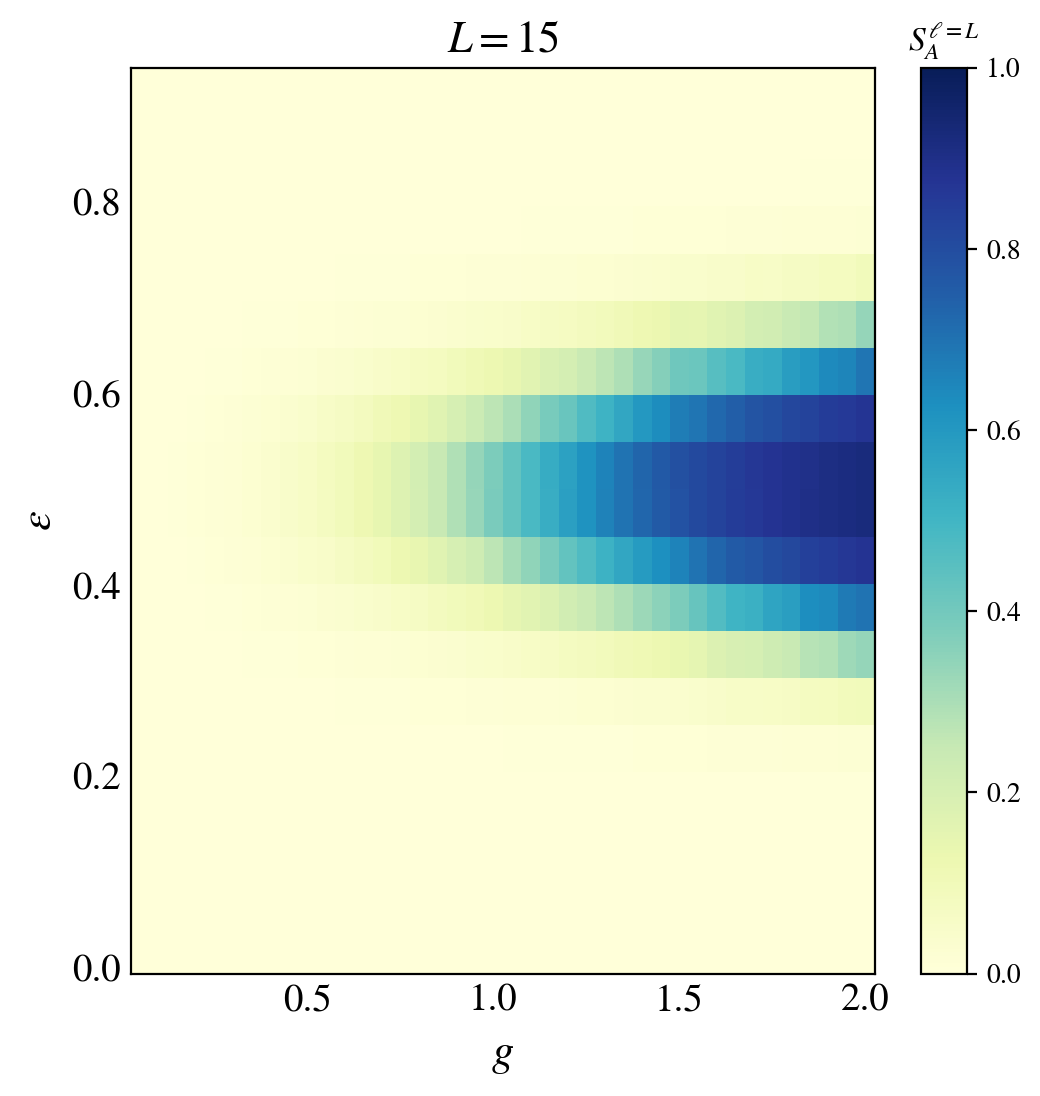

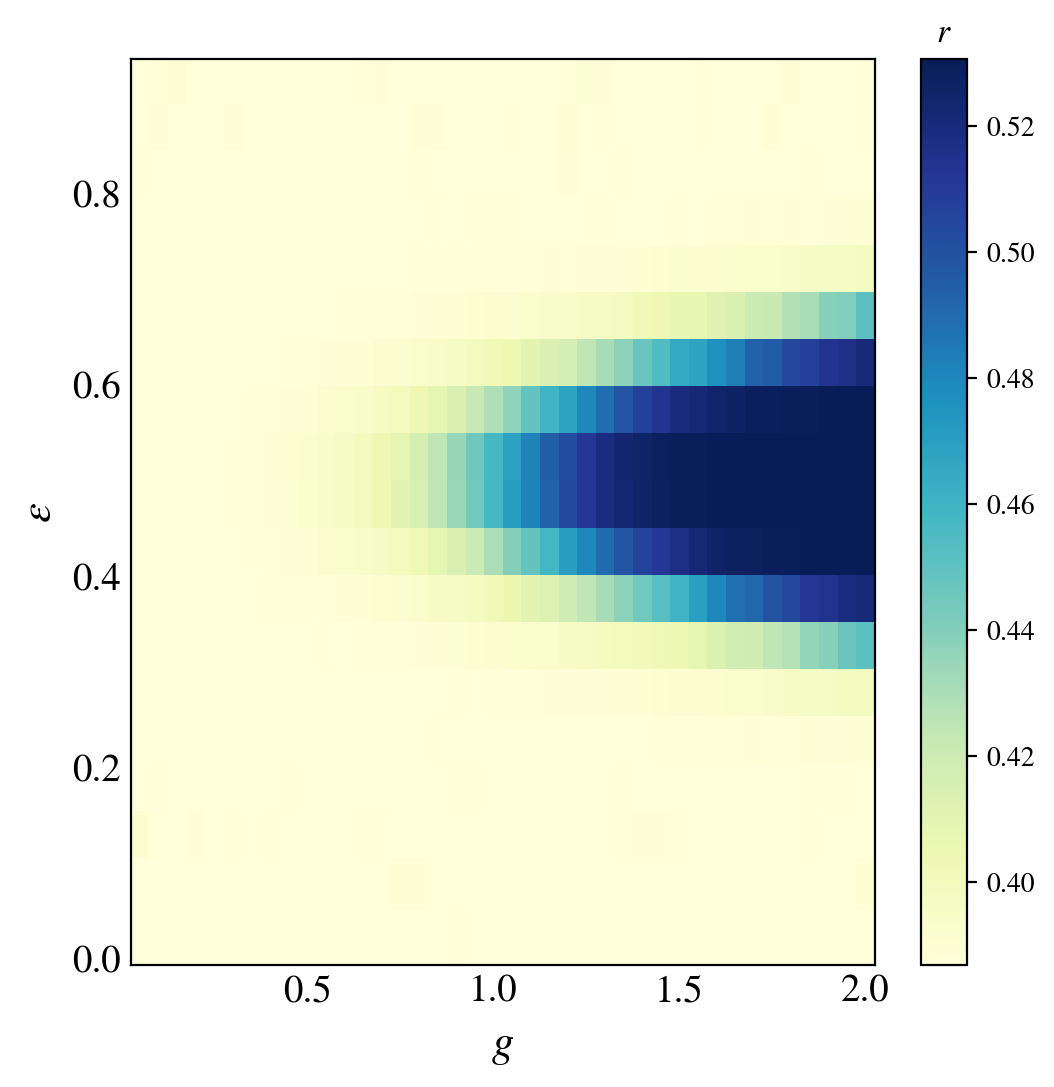

In [15]:

markers = itertools.cycle(markers_ls)


L=15

fig1, axis1 = plt.subplots( nrows=1, ncols=1, figsize=(6,6), dpi = 200)
fig2, axis2 = plt.subplots( nrows=1, ncols=1, figsize=(6,6), dpi = 200)
axis = [axis1, axis2]

g=1

g_vals = np.linspace(0.05, 2, 40)

LA = L // 2

energy_density = None
entropy_density = []
gap_ratio_density = []
for ii, g in enumerate(g_vals):
    name = base_dir + 'Entropy/Eigenstate/' + info(L=L, g=g, ext='.hdf5')
    if exists(name):
        with h5py.File(name, "r") as file:
            energy_density = np.array(file.get('energy density'))[0:-1]
            S_dens = np.array(file.get('entropy density'))[LA][0:-1]
            gap_ratio = np.array(file.get('gap ratio density'))[0:-1]
            
            entropy_density.append(S_dens / page(LA, L - LA))
            gap_ratio_density.append(gap_ratio)  
    else:
        print(name)
# print(gap_ratio_density)

energy_density = np.array(energy_density)
entropy_density = np.array(entropy_density)

#white = plt.get_cmap('seismic', 100)(0.5*np.ones(1))
upper = plt.get_cmap('YlGnBu', 100)(np.linspace(0.0, 1.0, 100))
colors = np.vstack((upper))  

mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

X, Y = np.meshgrid(g_vals, energy_density)

p = axis1.pcolormesh(X, Y, np.transpose(entropy_density), shading='nearest', cmap=mymap, vmin=0, vmax=1)
fig_help.set_plot_elements(axis1, ylabel=r"$\epsilon$", xlabel=r"$g$", font_size=14, set_legend=False)
axis1.set_title(r"$L=%d$"%(L), fontsize=16)
clb = fig1.colorbar(p)
clb.ax.set_title(r"$S^{\ell=L}_A$")

p = axis2.pcolormesh(X, Y, np.transpose(gap_ratio_density), shading='nearest', cmap=mymap, vmin=0.3869, vmax=0.5307)
fig_help.set_plot_elements(axis2, ylabel=r"$\epsilon$", xlabel=r"$g$", font_size=14, set_legend=False)
clb2 = fig2.colorbar(p)
clb2.ax.set_title(r"$r$")

# axis.xaxis.set_minor_locator(plt.NullLocator())
# axis.yaxis.set_minor_locator(plt.NullLocator())

#legend = axis.legend(frameon=1, fontsize=14, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.0,1.0), facecolor="gray")
plt.show()

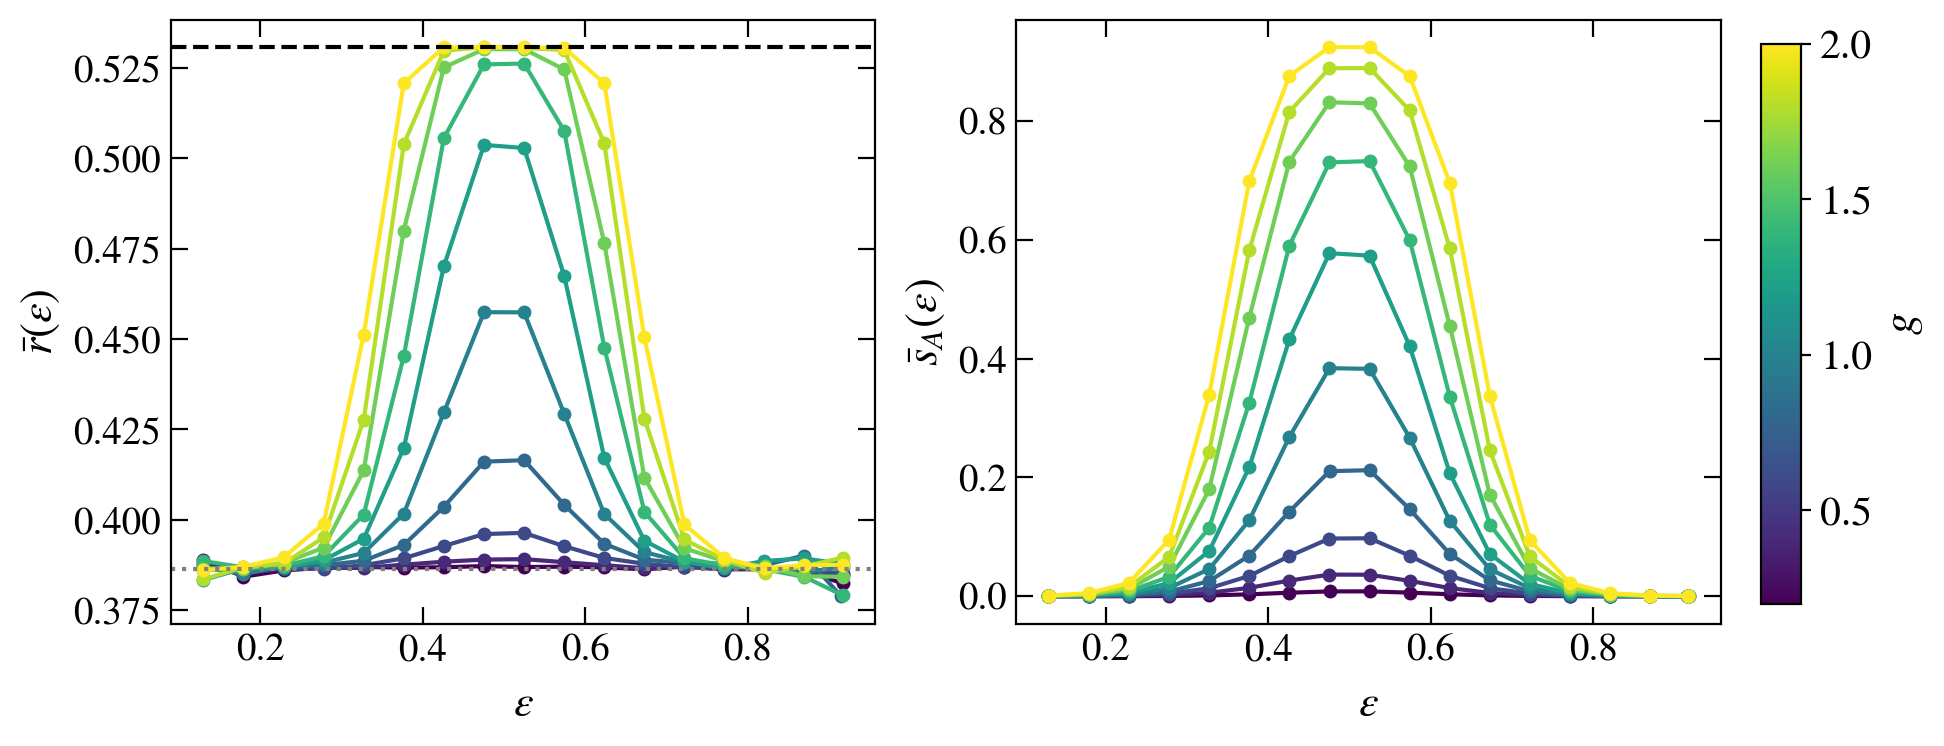

In [16]:

markers = itertools.cycle(markers_ls)


L=15

fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,4), dpi = 200)

g=1

g_vals = np.linspace(0.05, 2, 40)
g_vals = np.arange(0.2, 2.2, 0.2)

LA = L // 2
norm = matplotlib.colors.Normalize(
    vmin=np.min(g_vals),
    vmax=np.max(g_vals))


# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap='viridis', norm=norm)
s_m.set_array([])

for ii, g in enumerate(g_vals):
    col = s_m.to_rgba(g)

    name = base_dir + 'Entropy/Eigenstate/' + info(L=L, g=g, ext='.hdf5')
    if exists(name):
        with h5py.File(name, "r") as file:
            energy_density = np.array(file.get('energy density'))[2:-1]
            S_dens = np.array(file.get('entropy density'))[LA][2:-1]
            gap_ratio = np.array(file.get('gap ratio density'))[2:-1]
            
            S_dens = S_dens / page(LA, L - LA)

            axis[0].plot(energy_density, gap_ratio, marker='o', markersize=4, color=col)
            axis[1].plot(energy_density, S_dens,    marker='o', markersize=4, color=col)
    else:
        print(name)

fig_help.set_plot_elements(axis[0], xlabel=r"$\epsilon$", ylabel=r"$\bar{r}(\epsilon)$", font_size=14, set_legend=False)
fig_help.set_plot_elements(axis[1], xlabel=r"$\epsilon$", ylabel=r"$\bar{s}_A(\epsilon)$", font_size=14, set_legend=False)

axis[0].axhline(y=0.3863, ls=':', color='gray')
axis[0].axhline(y=0.5307, ls='--', color='black')
# axis.xaxis.set_minor_locator(plt.NullLocator())
# axis.yaxis.set_minor_locator(plt.NullLocator())
 
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
# fig.colorbar(im, cax=cbar_ax)
cbar = fig.colorbar(s_m, cax=cbar_ax, aspect=1)
cbar.set_label(r"$g$", fontsize=16)
cbar.ax.tick_params(labelsize=15)

#legend = axis.legend(frameon=1, fontsize=14, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.0,1.0), facecolor="gray")
plt.show()

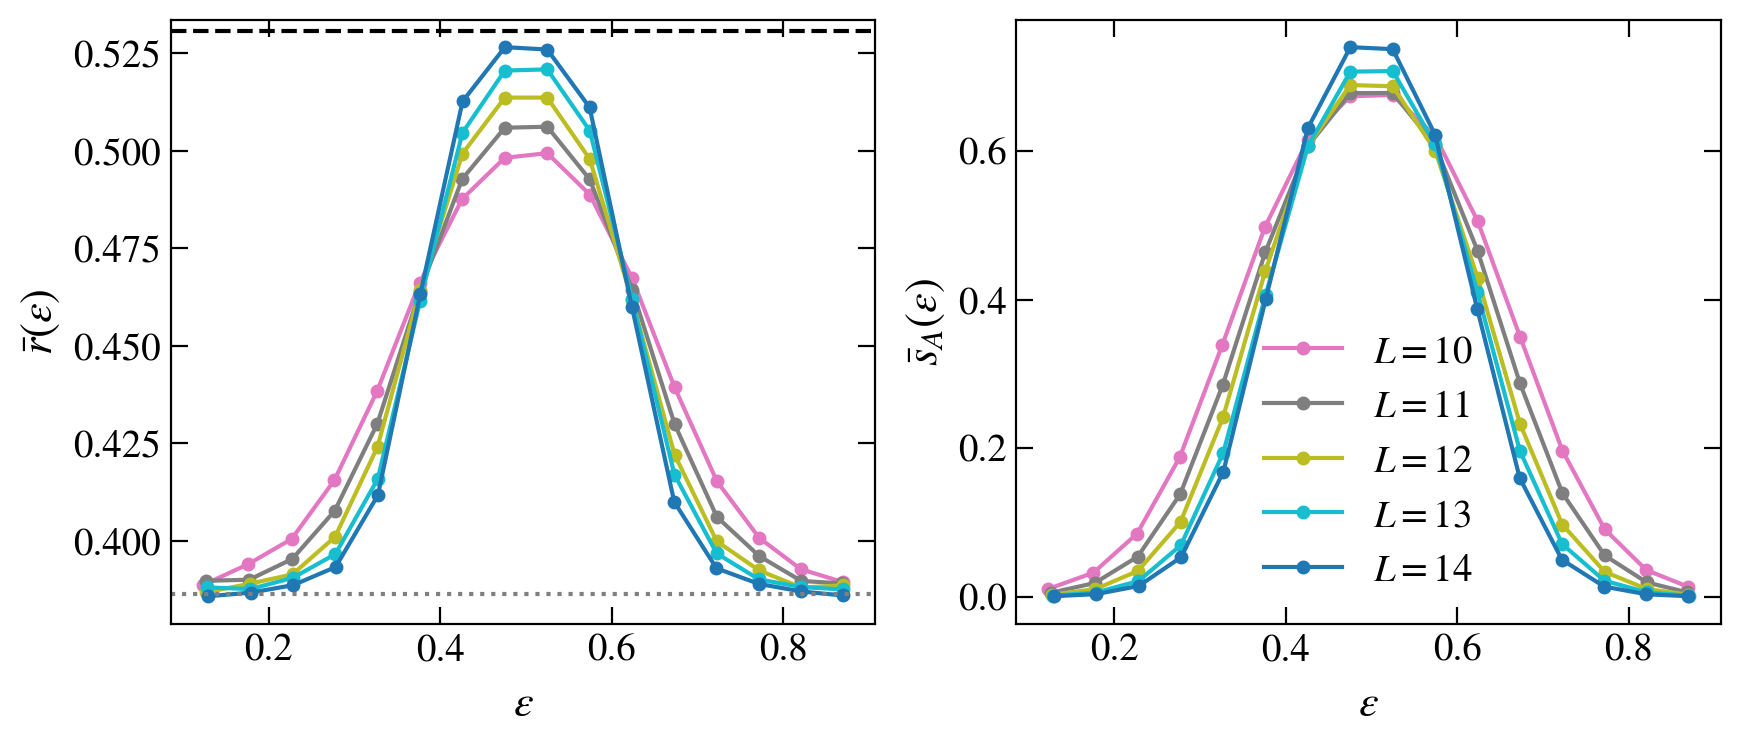

In [17]:

markers = itertools.cycle(markers_ls)


L=15

fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,4), dpi = 200)

g=1.5

sizes = np.arange(10, 15, 1)

for ii, L in enumerate(sizes):
    col = next(colors_ls_cyc)

    name = base_dir + 'Entropy/Eigenstate/' + info(L=L, g=g, ext='.hdf5')
    if exists(name):
        with h5py.File(name, "r") as file:
            energy_density = np.array(file.get('energy density'))[2:-2]
            S_dens = np.array(file.get('entropy density'))[LA][2:-2]
            gap_ratio = np.array(file.get('gap ratio density'))[2:-2]
            
            S_dens = S_dens / page(LA, L - LA)

            axis[0].plot(energy_density, gap_ratio, marker='o', markersize=4, color=col)
            axis[1].plot(energy_density, S_dens,    marker='o', markersize=4, color=col, label=r"$L=%d$"%L)
    else:
        print(name)

fig_help.set_plot_elements(axis[0], xlabel=r"$\epsilon$", ylabel=r"$\bar{r}(\epsilon)$", font_size=14, set_legend=False)
fig_help.set_plot_elements(axis[1], xlabel=r"$\epsilon$", ylabel=r"$\bar{s}_A(\epsilon)$", font_size=14, set_legend=True)

axis[0].axhline(y=0.3863, ls=':', color='gray')
axis[0].axhline(y=0.5307, ls='--', color='black')
# axis.xaxis.set_minor_locator(plt.NullLocator())
# axis.yaxis.set_minor_locator(plt.NullLocator())
 
#legend = axis.legend(frameon=1, fontsize=14, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.0,1.0), facecolor="gray")
plt.show()

In [18]:

markers = itertools.cycle(markers_ls)


L=15

fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(6,4), dpi = 200, sharey=True, sharex=True)

g=1

g_vals = np.linspace(0.05, 2, 40)
# g_vals = np.arange(0.2, 2.2, 0.2)

LA = L // 2
norm = matplotlib.colors.Normalize(
    vmin=np.min(0),
    vmax=np.max(1))


# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap='viridis', norm=norm)
s_m.set_array([])

E0 = np.zeros((g_vals.size))
for ii, g in enumerate(g_vals):

    name = base_dir + 'Entropy/Eigenstate/' + info(L=L, g=g, ext='.hdf5')
    if exists(name):
        with h5py.File(name, "r") as file:
            E = np.array(file.get('mean energies'))
            dim = E.size
            # print("Doing g=", g, dim)
            S = np.array(file.get('entropies'))[LA]
            gap_ratio = (np.array(file.get('gap ratio')) - 0.3867) / (0.5307 - 0.3867)
            
            S = S / page(LA, L - LA)
            # for ii in range(dim-2):
            gx = np.zeros((dim));   gx.fill(g)
            axis[0].scatter(gx[1:-1], E[1:-1], s=2, color=s_m.to_rgba(gap_ratio))
            axis[1].scatter(gx, E, s=2, color=s_m.to_rgba(S))
            E0[ii] = E[0]
    else:
        print(name)
# print(E0)
fig_help.set_plot_elements(axis[0], xlabel=r"$g$", ylabel=r"$\overline{E_n}$", font_size=14, set_legend=False)
fig_help.set_plot_elements(axis[1], xlabel=r"$g$", ylabel="", font_size=14, set_legend=False)
axis[0].set_title(r"$\frac{\overline{r_n}-r_{GOE}}{r_{GOE}-r_P}$", fontsize=16)
axis[1].set_title(r"$\overline{s^n_A}$", fontsize=16)
# axis.xaxis.set_minor_locator(plt.NullLocator())
# axis.yaxis.set_minor_locator(plt.NullLocator())
 
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
# fig.colorbar(im, cax=cbar_ax)
cbar = fig.colorbar(s_m, cax=cbar_ax, aspect=1)
# cbar.set_label(r"$r_n\ ,\ s^n_A$", fontsize=16)
cbar.ax.tick_params(labelsize=15)
fig.subplots_adjust(wspace = 0.02, hspace=0.02)

Error in callback <function flush_figures at 0x7fbb88d48310> (for post_execute):


KeyboardInterrupt: 

## MATRIX ELEMENTS

[ 0.316228  0.354813  0.398107  0.446684  0.501187  0.562341  0.630957
  0.707946  0.794328  0.891251  1.        1.122018  1.258925  1.412538
  1.584893  1.778279  1.995262  2.238721  2.511886  2.818383  3.162278
  3.548134  3.981072  4.466836  5.011872  5.623413  6.309573  7.079458
  7.943282  8.912509 10.       11.220185 12.589254 14.125375 15.848932
 17.782794 19.952623 22.387211 25.118864 28.183829 31.622777 35.481339
 39.810717 44.668359 50.118723 56.234133 63.095734 70.794578 79.432823
 89.125094]
10 5000.0
11 4901.0
12 4000.0
13 3000.0
14 1704.0
10 5000.0
11 4901.0
12 4000.0
13 3000.0
14 1704.0


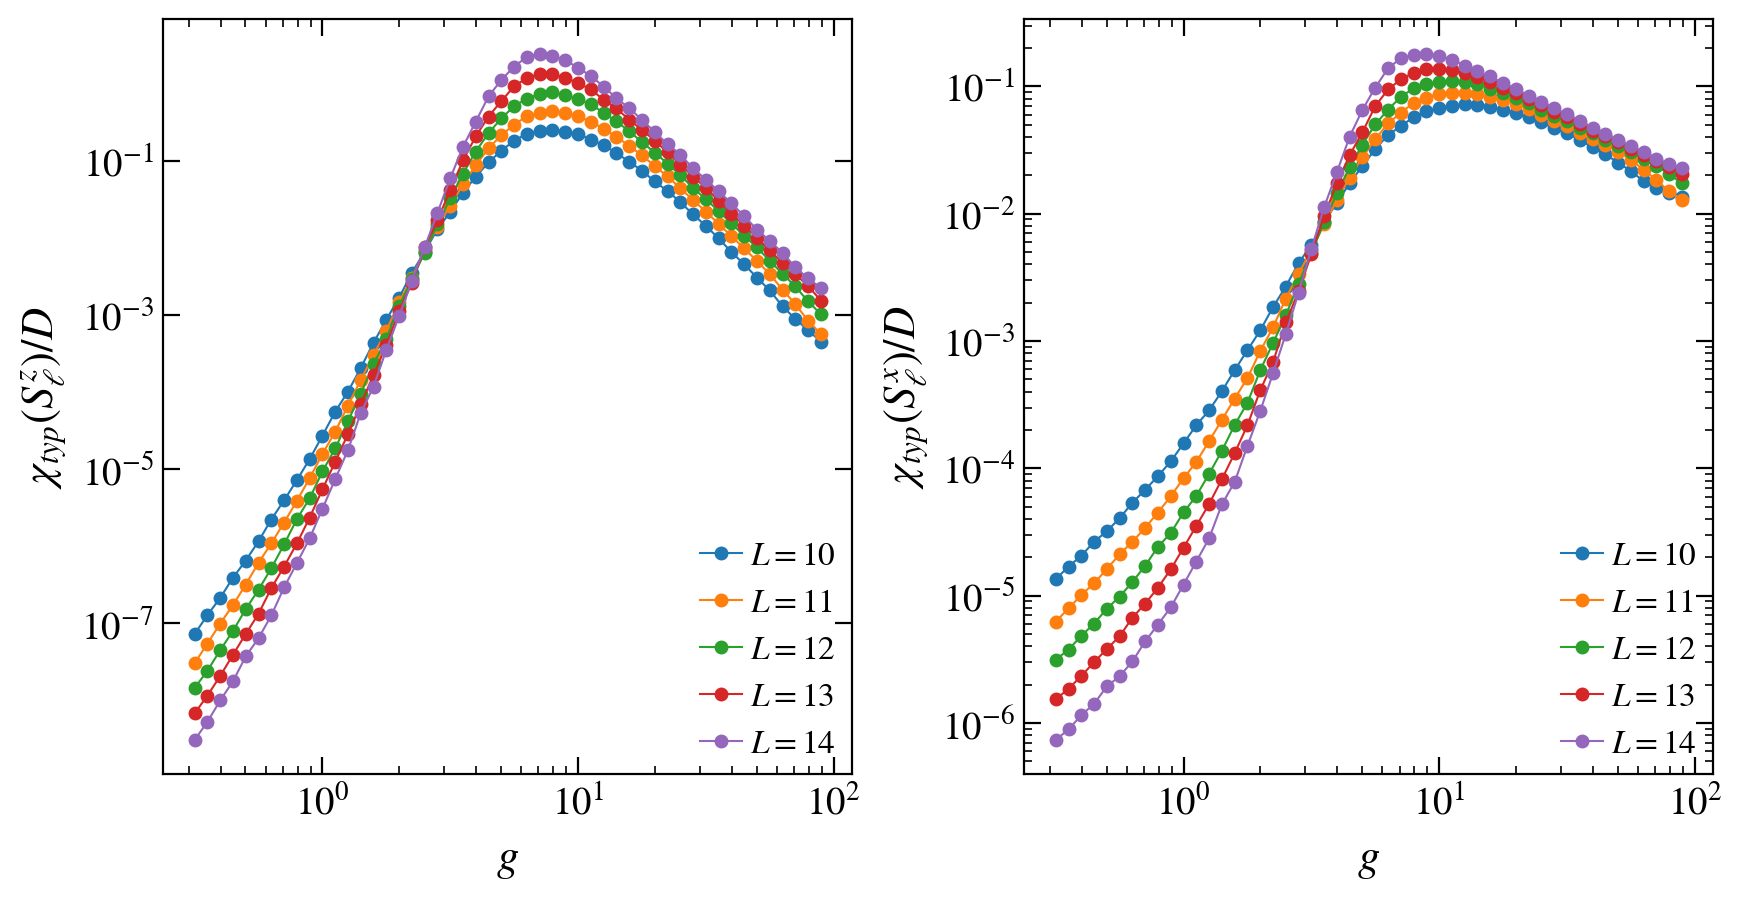

In [55]:
L=15

J=1
g=1
scaled_disorder = 1

# w_vals = np.unique( np.round( np.array( [ *np.linspace(0.4, 1.3, 19), *np.linspace(0.7, 0.82, 13)] ), 3) )
g_vals = np.linspace(0.2, 12.0, 60)
# g_vals = np.linspace(0.2, 12, 60)
g_vals = np.round(np.logspace(-0.5, 1.95, 50),6)
print(g_vals)

sizes = np.arange(10, 15, 1)

xlab = r"$g$"

fig, axes = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 200, sharex=True)
ylab_in = ['S^z_\ell', 'S^x_\ell', 'S^z_\ell S^z_{\ell+1}', 'S^x_\ell S^x_{\ell+1}', 'K_\ell']
axes = axes.flatten()
for iii, operator_name in enumerate(['Sz', 'Sx']):
    p=0
    axis = axes[iii]
    if iii > 1: p=1
    for L in sizes:
        # g_vals = np.linspace(0.2, 12.0, 60) if L > 12 else np.linspace(0.1, 11.9, 60)
        dim = 2**L
        num_sites = L
        sites    = np.zeros((num_sites));    sites.fill(np.nan)
        agp      = np.zeros((g_vals.size, num_sites - p));    agp.fill(np.nan)
        typ_susc = np.zeros((g_vals.size, num_sites - p));    typ_susc.fill(np.nan)
        _var     = np.zeros((g_vals.size, num_sites - p));    _var.fill(np.nan)
        wH       = np.zeros((g_vals.size));                 wH.fill(np.nan)
        realisations = np.zeros((g_vals.size));             realisations.fill(np.nan)
        # susc = np.zeros((L));    sites.fill(np.nan)
        _exist = 0
        for ii, g in enumerate(g_vals):
            name = base_dir + 'MatrixElements/' + info(L=L, g=g, ext='.hdf5')
            if exists(name):
                with h5py.File(name, "r") as file:
                    sites        = np.array(file.get('sites')).astype(int)
                    agp[ii]      = np.array(file.get('AGP/' + operator_name))
                    # print('AGP/' + name)
                    typ_susc[ii] = np.array(file.get('TYP_SUSC/' + operator_name))
                    # mat_elem = np.transpose(np.array(file.get('DIAG_MAT/' + operator_name)))
                    # _var[ii]     = np.array([np.var(aa) for aa in mat_elem])
                    realisations[ii] = np.array(file.get('realisations'))
                    _exist = 1
            else:
                print(name)
            # name = base_dir + '

        if _exist:                
            print(L, min(realisations) )

            agp = np.transpose(agp)
            _var = np.transpose(_var)
            typ_susc = np.transpose(typ_susc)
            
            # _sites_ = [0, L//2, L - 2]
            # print(sites)
            # for ii, ell in enumerate(_sites_):
            idx = 0
            # axis.plot(g_vals, agp[idx] / dim, marker='o', label=r"$L+N=%d$"%L, markersize=4, lw=1)
            axis.plot(g_vals, typ_susc[idx] / dim, marker='o', label=r"$L=%d$"%L, markersize=4, lw=0.75)
            # print(_var(idx))
            # axis[ii].plot(w_vals, np.sqrt(_var[idx] * dim), marker='o', label=r"$L+N=%d$"%L)

    # ylab = r"$D(\omega_H)^2\chi(S^z_\ell)/L_{tot}$"
    ylab = r"$\chi_{typ}(%s)/D$"%ylab_in[iii]
    # ylab = r"$\sigma(%s)D$"%ylab_in[iii]
    # ylab = r"$||%s||^2/D$"%ylab_in[iii]
    fig_help.set_plot_elements(axis, ylabel=ylab, xlabel=xlab, font_size=14, set_legend=False, yscale='log', xscale='log')
    fig_help.set_legend(axis, loc = 'lower right', fontsize=12)#, anchor=(-0.02, 0.35))

    fig.subplots_adjust(wspace = 0.25, hspace=0.05)

# plt.savefig("Fig_mat_elem.pdf", bbox_inches = 'tight', pad_inches=0.02)
# plt.savefig("Fig_mat_elem.png", bbox_inches = 'tight', pad_inches=0.02)